In [1]:
#2024.11.30

import pandas as pd 
import numpy as np
import gc
dfrac = pd.read_csv(r'./RACs.csv')                  # all MOFs including the theoretical ones
dfgeo = pd.read_csv(r'./geometric_properties.csv')
dfX = pd.read_csv(r'./20MOFX_right.csv')

In [2]:
dfrac_EMOF=dfrac.iloc[list(np.where(dfrac['DB_num']=='DB14')[0])+list(np.where(dfrac['DB_num']=='DB12')[0])]    # experimentally available MOFs
dfgeo_EMOF=dfgeo.iloc[list(np.where(dfgeo['DB_num']=='DB14')[0])+list(np.where(dfgeo['DB_num']=='DB12')[0])]

In [3]:
#remove unuseful columns
dfrac = dfrac.iloc[:, 1:-10]
dfgeo = dfgeo.iloc[:, 1:-4]
dfrac_EMOF = dfrac_EMOF.iloc[:, 1:-10]
dfgeo_EMOF = dfgeo_EMOF.iloc[:, 1:-4]

In [4]:
# Assuming you have two DataFrames df and dfg with a common column 'filename'
# Merging the DataFrames on 'filename' with inner join to keep only common entries
merged_df = pd.merge(dfrac, dfgeo, on='filename', how='inner')
merged_df_EMOF = pd.merge(dfrac_EMOF, dfgeo_EMOF, on='filename', how='inner')
del dfrac  # Delete the DataFrame
del dfgeo  # Delete the DataFrame
del dfrac_EMOF  # Delete the DataFrame
del dfgeo_EMOF  # Delete the DataFrame
gc.collect()  # Run garbage collection

0

In [5]:
#Remove the columns that has low variance
from sklearn.preprocessing import StandardScaler
import numpy as np

merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.dropna(inplace=True)
merged_df_EMOF.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df_EMOF.dropna(inplace=True)

# make sure all the columns are numerical values
# merged_df = merged_df.select_dtypes(include=[np.number])

print(merged_df.shape)

# standardize
scaler = StandardScaler()
scaler.fit(merged_df.drop(columns=['filename']))
# convert the raw data using the standardizing method
scaled_merged_df = scaler.transform(merged_df.drop(columns=['filename']))  #all MOFs
MOF_index = dfX['MOF_index']
MOF_name = dfX['MOF']
dfX = dfX[merged_df.drop(columns=['filename']).columns]
scaled_dfX = scaler.transform(dfX)   #MOFs used in this study
dfEMOF = merged_df_EMOF[merged_df.drop(columns=['filename']).columns]  #experimentally available MOFs
scaled_dfEMOF = scaler.transform(dfEMOF)
# data standardization
df_standardized = pd.DataFrame(scaled_merged_df, columns=merged_df.drop(columns=['filename']).columns)
print(df_standardized.shape)
dfX_standardized = pd.DataFrame(scaled_dfX, columns=dfX.columns)
print(dfX_standardized.shape)
dfEMOF_standardized = pd.DataFrame(scaled_dfEMOF, columns=dfEMOF.columns)
print(dfEMOF_standardized.shape)

# del merged_df  # Delete the DataFrame
# gc.collect()  # Run garbage collection

# Remove the columns that has low variance
column_to_keep = (df_standardized.std() > 0) # a number that can be ajusted
df_standardized = df_standardized.loc[:, column_to_keep]  
dfX_standardized = dfX_standardized.loc[:, column_to_keep]  
dfEMOF_standardized = dfEMOF_standardized.loc[:, column_to_keep]
print(df_standardized.shape)
print(dfX_standardized.shape)
print(dfEMOF_standardized.shape)

(472494, 200)
(472494, 199)
(24, 199)
(11345, 199)
(472494, 171)
(24, 171)
(11345, 171)


In [6]:
#Test if factor analysis is suitable
import pandas as pd
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# # removing low variance columns
# df_standardized = df_standardized.loc[:, df_standardized.std() > 0.05]  # adjustable number

# examining feasibility using some figure of merits
chi_square_value, p_value = calculate_bartlett_sphericity(df_standardized.values)
kmo_all, kmo_model = calculate_kmo(df_standardized.values)

# the results
print("Bartlett's Test Value:", chi_square_value, "P-value:", p_value)
print("KMO Test Value:", kmo_model)


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\factor_analyzer\factor_analyzer.py:109: RuntimeWarning: divide by zero encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)
c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


Bartlett's Test Value: inf P-value: 0.0
KMO Test Value: 0.8350236043955536


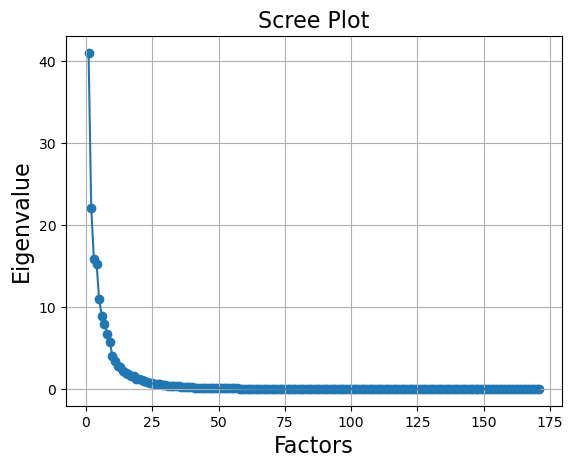

45


In [7]:
from matplotlib import pyplot as plt
# select the number of factors
fa = FactorAnalyzer(rotation=None, n_factors=3, method='minres')
fa.fit(df_standardized.values)

# factor loadings
loadings = fa.loadings_
# print(loadings)

# Scree plot for determining the number of factors

ev, v = fa.get_eigenvalues()
plt.scatter(range(1, df_standardized.shape[1]+1), ev)
plt.plot(range(1, df_standardized.shape[1]+1), ev)
plt.title('Scree Plot', fontsize=16)
plt.xlabel('Factors',fontsize=16)
plt.ylabel('Eigenvalue',fontsize=16)
plt.grid()
plt.show()
#selected the number of factors to consider
consider_threshold = 0.1
Num_factor_selected = sum(ev>consider_threshold)
print(Num_factor_selected)

In [8]:
# initializing the factor
fa = FactorAnalyzer(n_factors=Num_factor_selected, rotation='varimax')  # n_factors is the number of factors，adjustable
# fa = FactorAnalyzer(n_factors=Num_factor_selected, rotation=None)  # n_factors is the number of factors，adjustable
# factor analysis
fa.fit(df_standardized.values)  #on all MOFs

# get factor loadings
factor_loadings = fa.loadings_

# convert loadings to DataFrame
columns = [f'Factor{i+1}' for i in range(factor_loadings.shape[1])]
loadings_df = pd.DataFrame(factor_loadings, index=df_standardized.columns, columns=columns)

In [9]:
#calculate the Bartlett scores
n_factors = factor_loadings.shape[1]
lambda_ = 0.001  # regularization parameter
I = np.eye(fa.corr_.shape[0])  
model_implied_cov_inv = np.linalg.pinv(fa.corr_+I)
factor_score_coefficients = np.linalg.pinv(factor_loadings.T @ model_implied_cov_inv @ factor_loadings) @ factor_loadings.T @ model_implied_cov_inv
factor_score_coefficients_df = pd.DataFrame(factor_score_coefficients.T, index=df_standardized.columns, columns=columns)

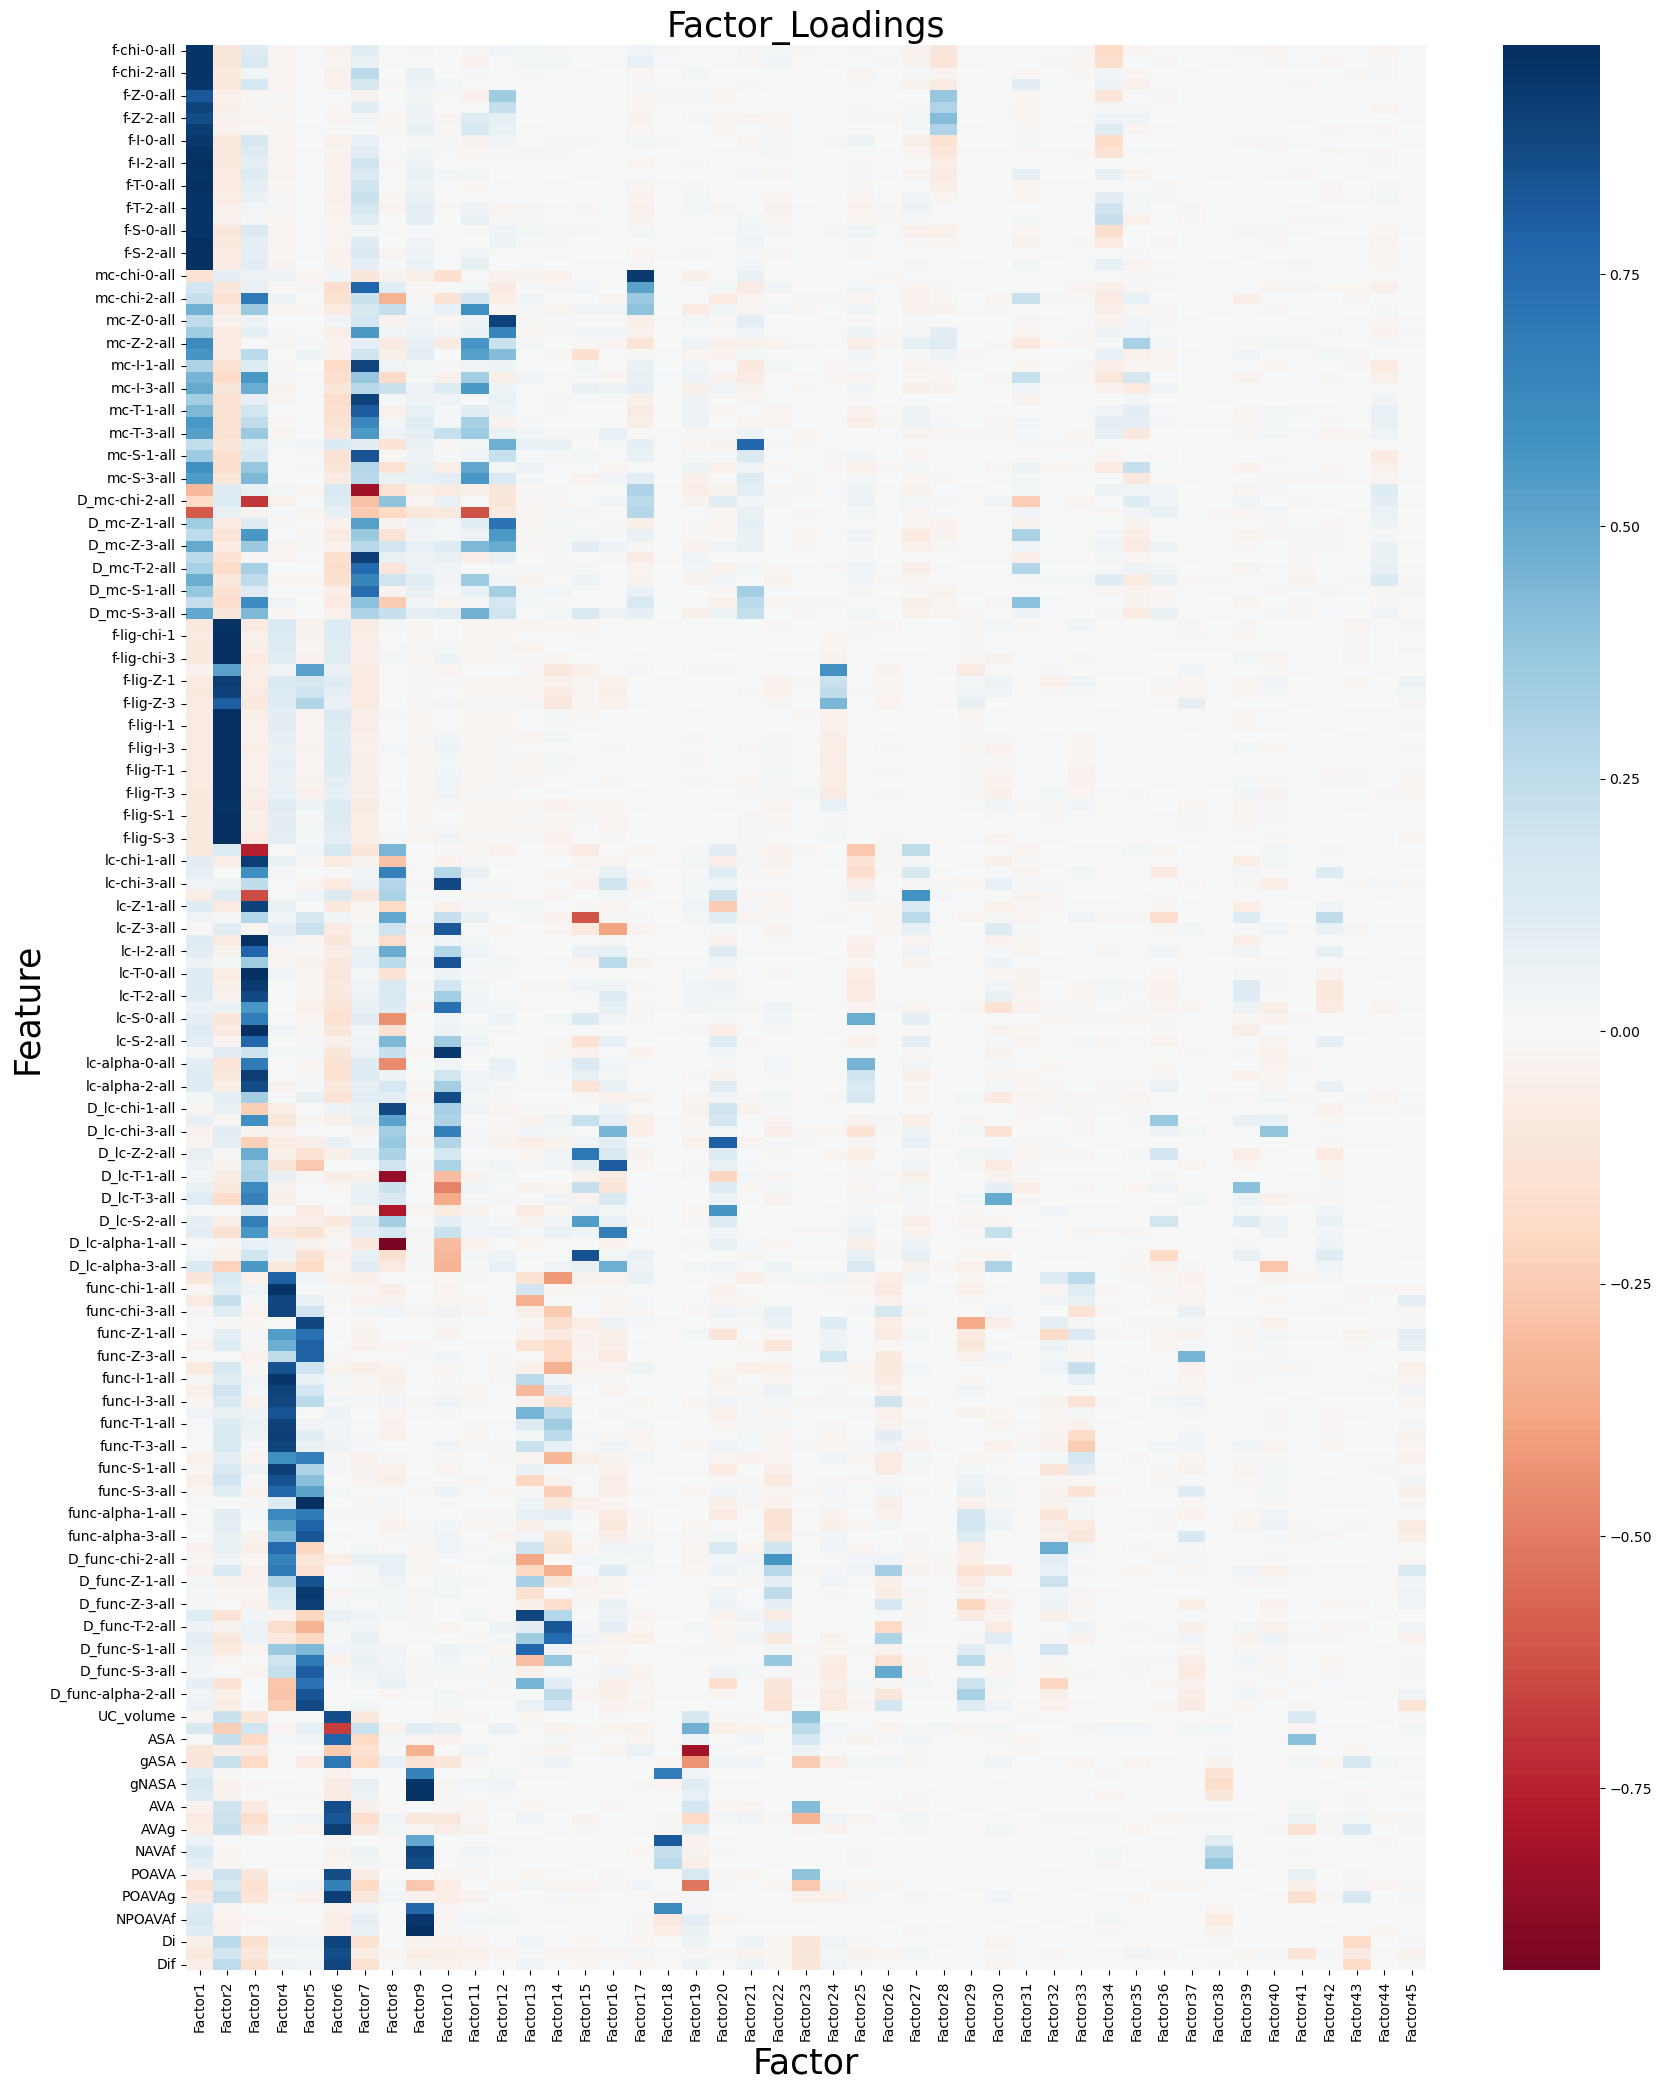

In [10]:
import seaborn as sns
# visualizing factor loadings
plt.figure(figsize=(20, 25))
sns.heatmap(loadings_df, cmap='RdBu', center = 0, annot=False)
plt.title('Factor_Loadings', fontsize=25)
plt.xlabel('Factor', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.show()

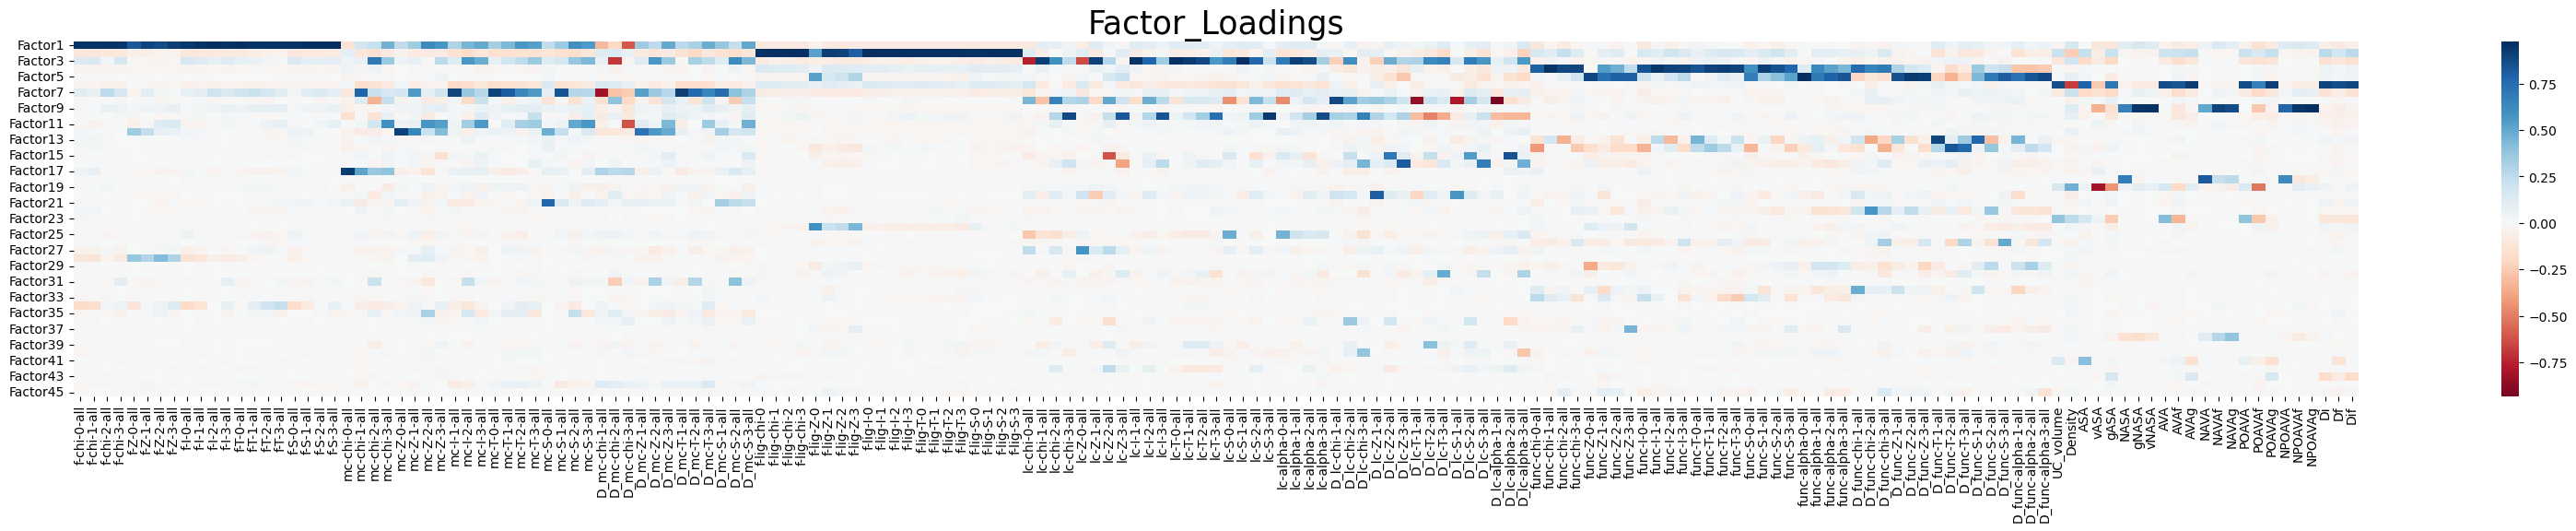

In [11]:
# visualizing factor loadings
plt.figure(figsize=(40, 5))
sns.heatmap(loadings_df.T, cmap='RdBu', center = 0, annot=False)
plt.title('Factor_Loadings', fontsize=25)
plt.show()

In [12]:
framework_desc=[]
mc_desc=[]
lc_desc=[]
func_desc=[]
lig_desc=[]
pore_desc=[]
for descriptor in list(loadings_df.index):
    if 'f-lig' in descriptor:
        lig_desc.append(descriptor)
    elif 'f-' in descriptor:
        framework_desc.append(descriptor)
    elif 'mc-' in descriptor:
        mc_desc.append(descriptor)
    elif 'lc-' in descriptor:
        lc_desc.append(descriptor)
    elif 'func' in descriptor:
        func_desc.append(descriptor)
    else:
        pore_desc.append(descriptor)

In [13]:
from sklearn.preprocessing import MinMaxScaler
loading_values = (loadings_df.values.T)**2
loading_values = pd.DataFrame(loading_values, columns=loadings_df.index)
categorizing_sum = np.zeros((loadings_df.shape[1],6))
for descriptor in list(loadings_df.index):
    if descriptor in framework_desc:
        categorizing_sum[:,0] += np.abs(loading_values[descriptor])
    elif descriptor in mc_desc:
        categorizing_sum[:,1] += np.abs(loading_values[descriptor])
    elif descriptor in lig_desc:
        categorizing_sum[:,2] += np.abs(loading_values[descriptor])
    elif descriptor in lc_desc:
        categorizing_sum[:,3] += np.abs(loading_values[descriptor])
    elif descriptor in func_desc:
        categorizing_sum[:,4] += np.abs(loading_values[descriptor])
    elif descriptor in pore_desc:
        categorizing_sum[:,5] += np.abs(loading_values[descriptor])

categorized_descriptors = {'framework':framework_desc,
                           'mc':mc_desc,
                           'lig':lig_desc,
                           'lc':lc_desc,
                           'func':func_desc,
                           'pore':pore_desc}

In [14]:
dominant_category = []
dominant_weight = []
for i in range(categorizing_sum.shape[0]):
    dominant_category.append(np.argmax(list(categorizing_sum[i])))
    dominant_weight.append(np.max(list(categorizing_sum[i])))

In [15]:
New_factors = []
for i in range(len(categorized_descriptors)):
    for j in range(45):
        if dominant_category[j] == i:
            New_factors.append(loadings_df.columns[j])

new_factor_loading_df = loadings_df[New_factors]

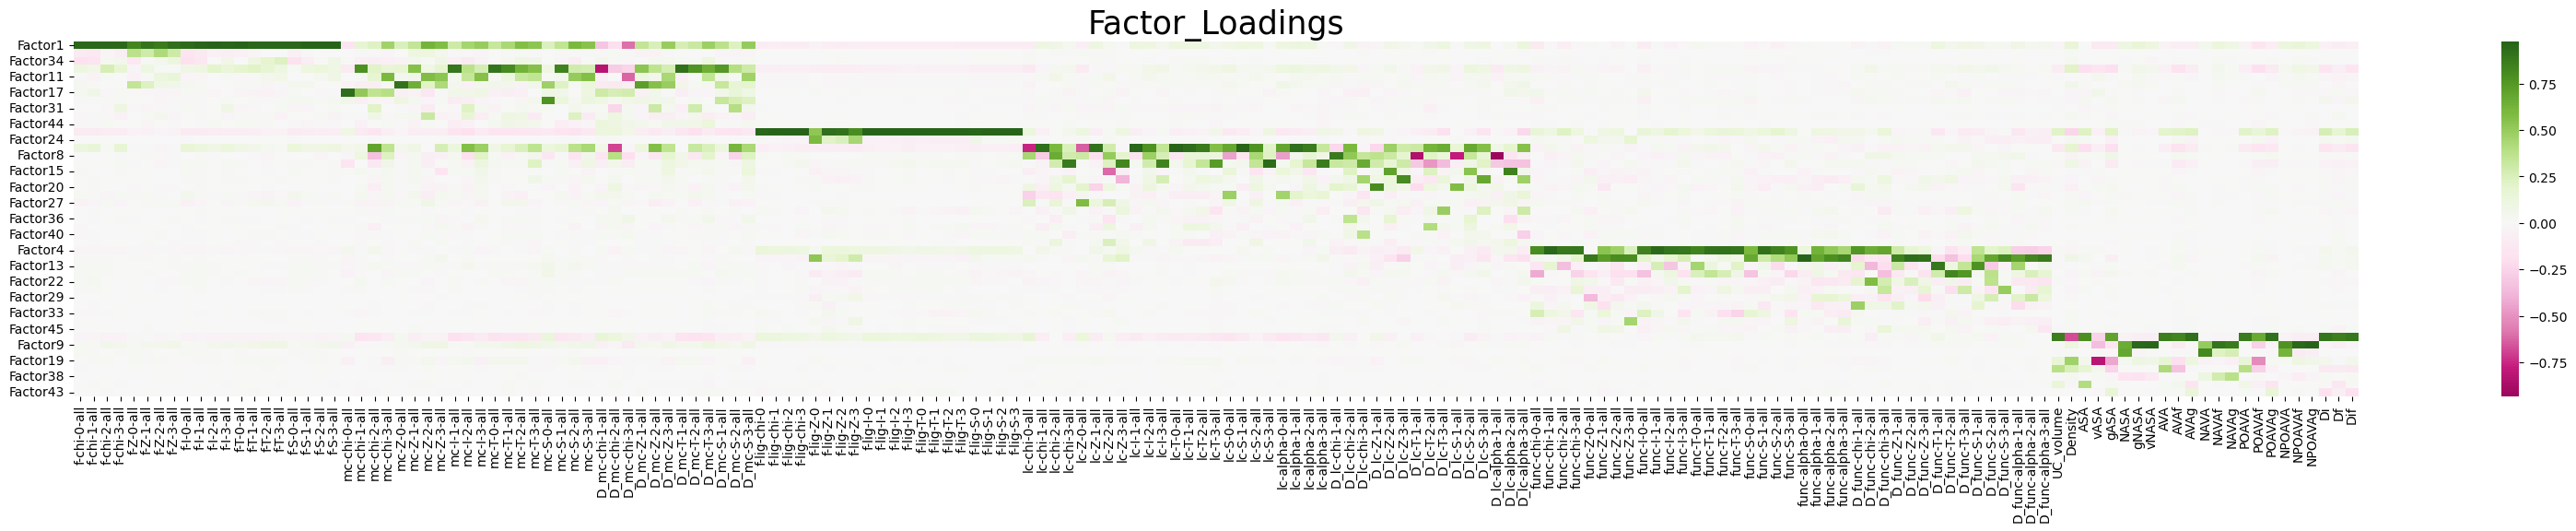

In [16]:
# visualizing factor loadings
from matplotlib.colors import LinearSegmentedColormap

plt.figure(figsize=(40, 5))
sns.heatmap(new_factor_loading_df.T, cmap='PiYG', center = 0, annot=False)
plt.title('Factor_Loadings', fontsize=25)
plt.show()

In [17]:
scaler = MinMaxScaler()
categorizing_sum = scaler.fit_transform(categorizing_sum.T).T
categorizing_sum = pd.DataFrame(categorizing_sum, columns=['framework','mc','lc','func','lig','pore'],index=loadings_df.columns)

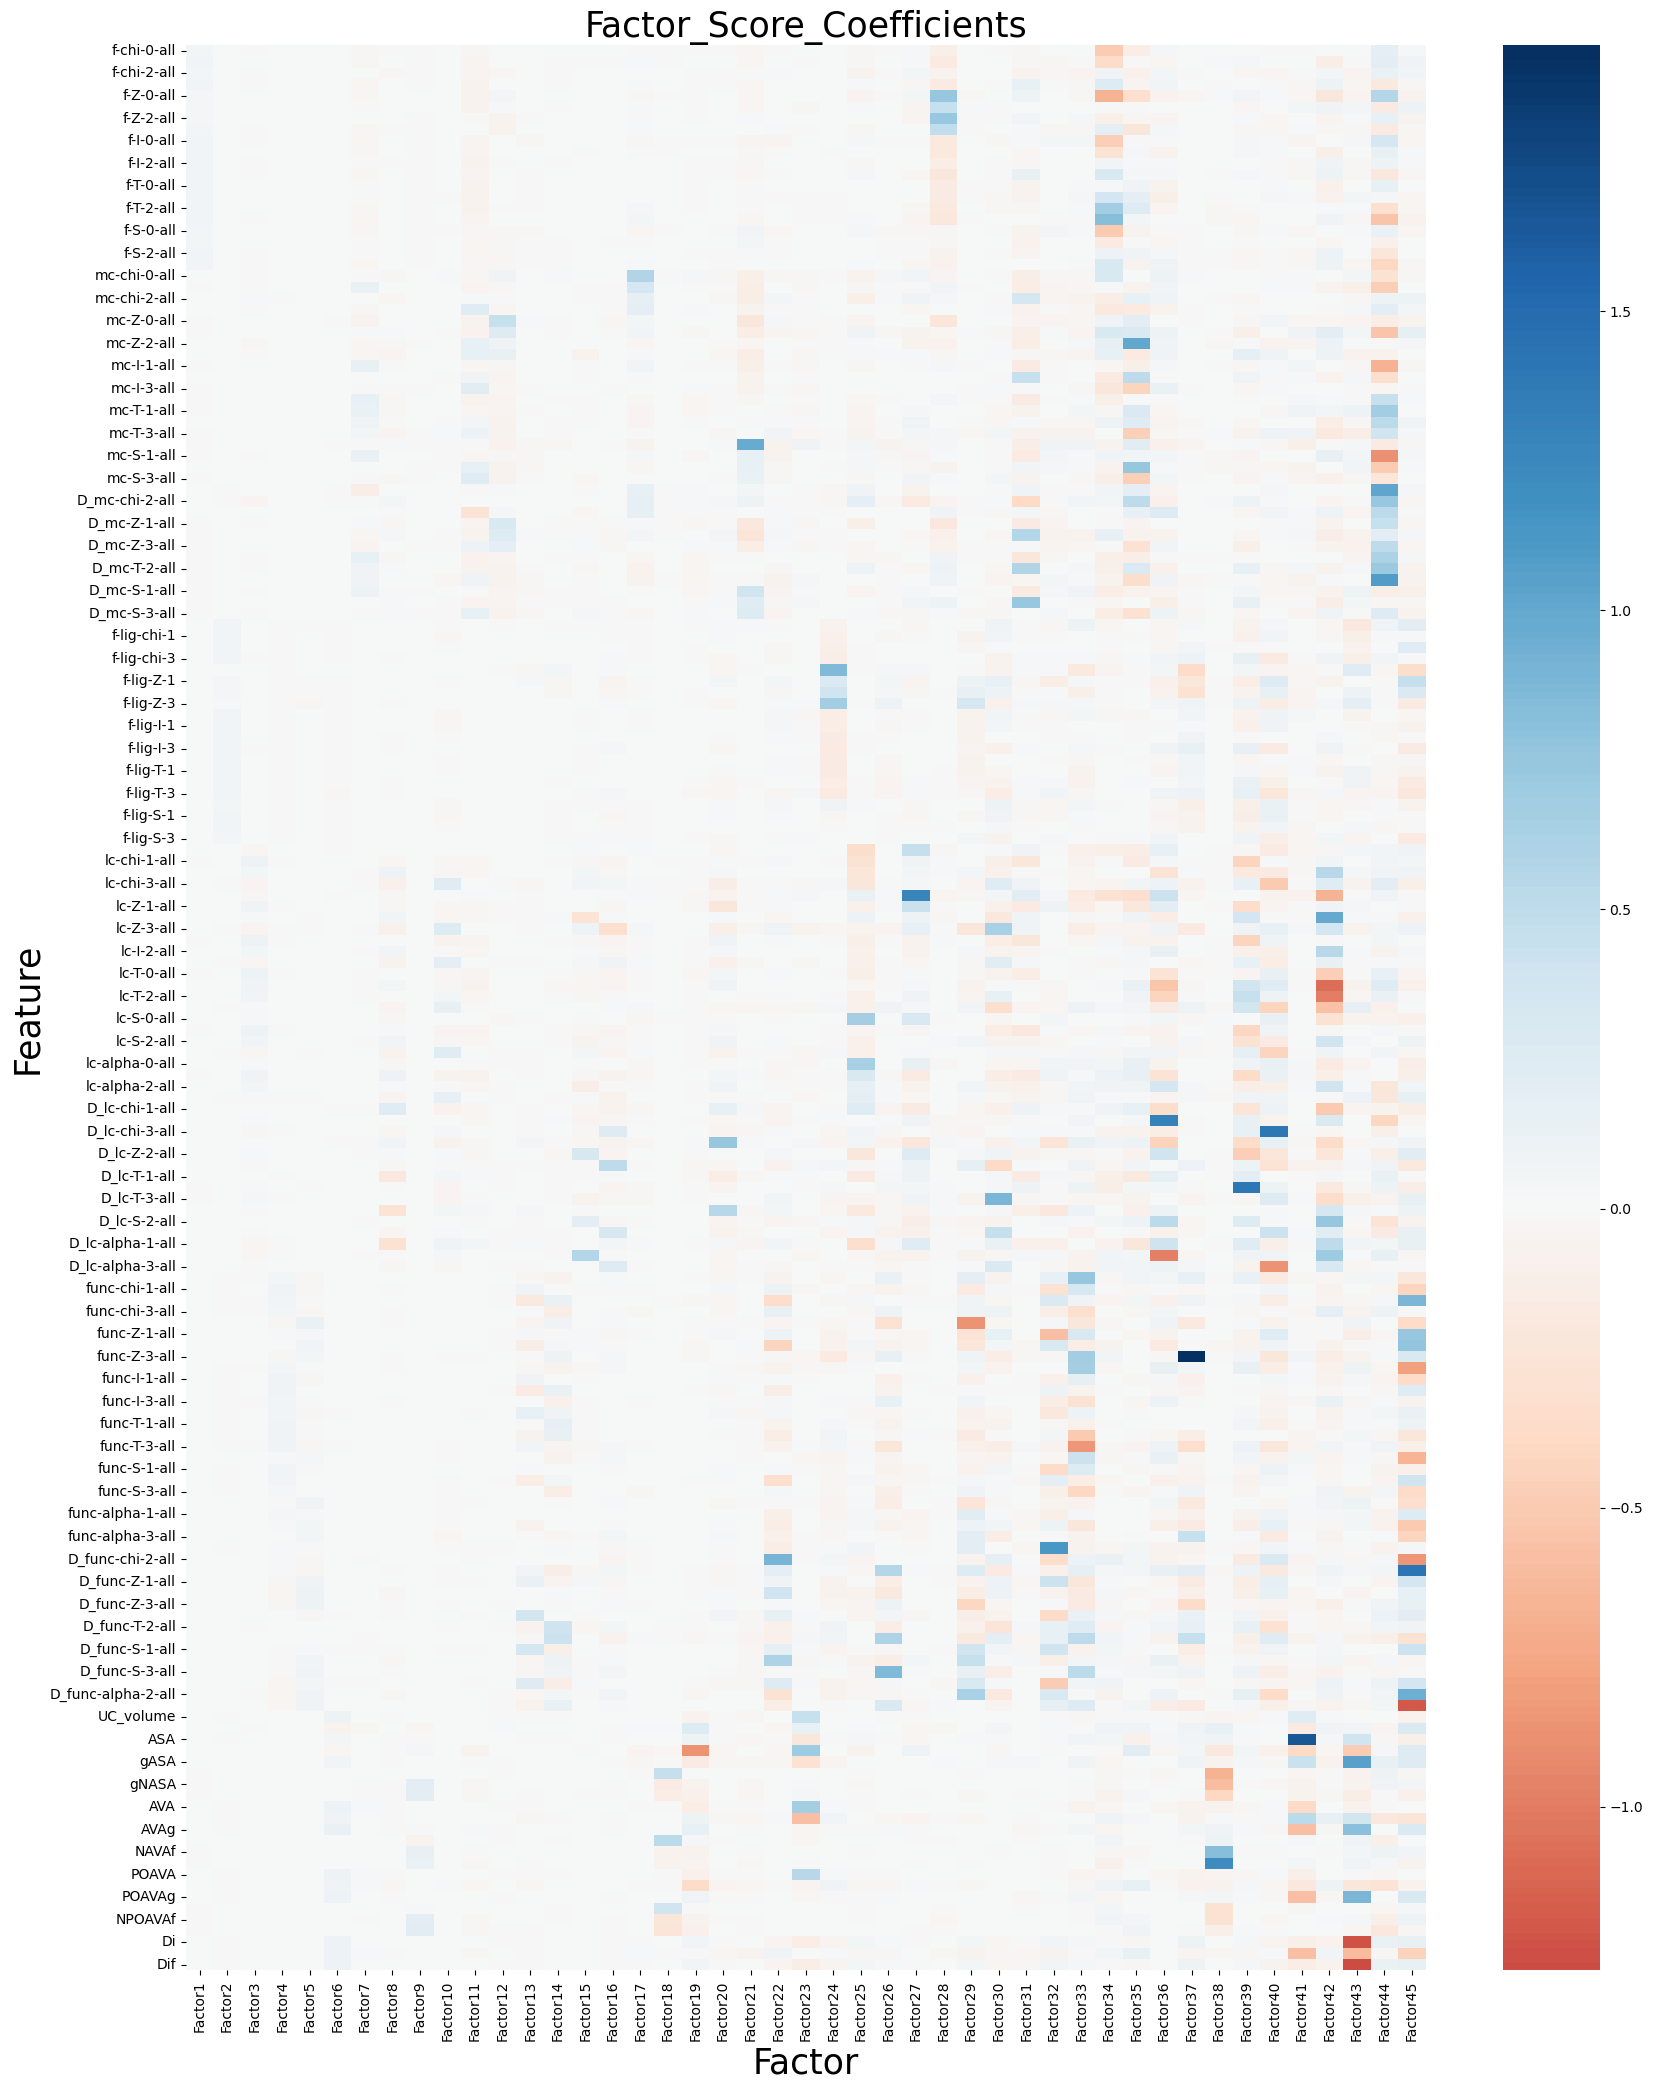

In [18]:
import seaborn as sns
# visualizing factor loadings
plt.figure(figsize=(20, 25))
sns.heatmap(factor_score_coefficients_df, cmap='RdBu', center = 0, annot=False)
plt.title('Factor_Score_Coefficients', fontsize=25)
plt.xlabel('Factor', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.show()

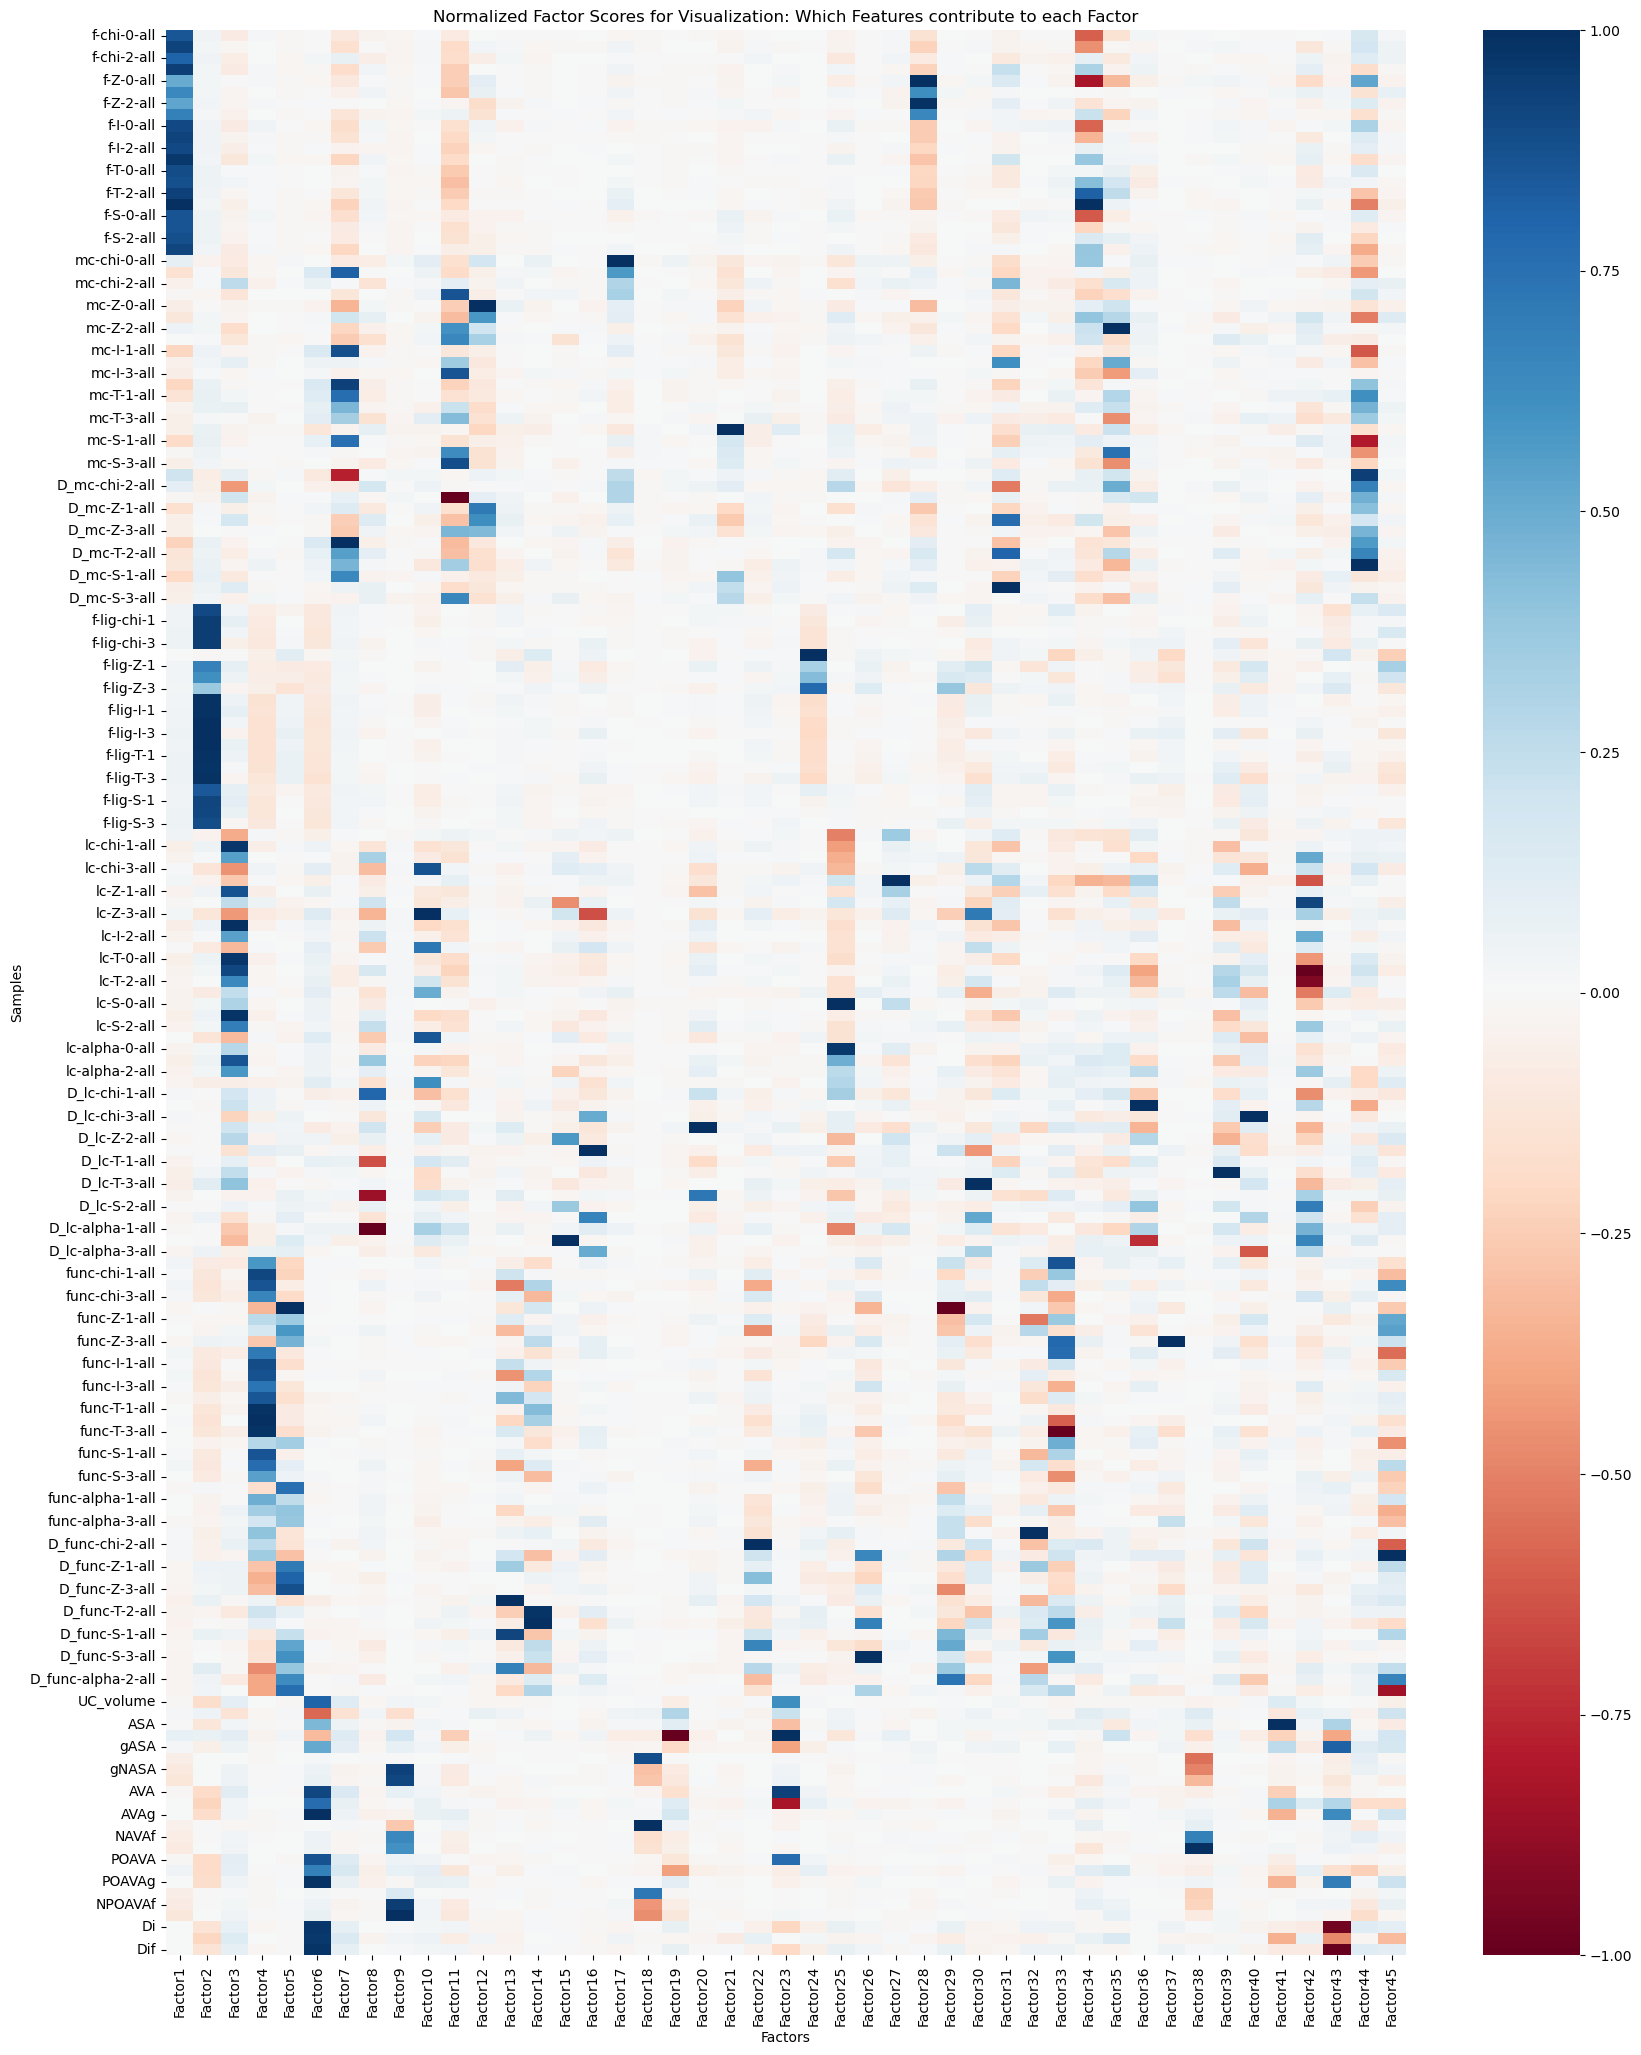

In [19]:
# Step 1: Normalize each column by dividing by the maximum absolute value in each column
normalized_factor_scores_df = factor_score_coefficients_df.apply(lambda x: x / np.max(np.abs(x)), axis=0)

# Step 2: Display the normalized DataFrame
# Visualizing the normalized factor scores

plt.figure(figsize=(20, 25))
sns.heatmap(normalized_factor_scores_df, cmap='RdBu', center=0, annot=False)
plt.title('Normalized Factor Scores for Visualization: Which Features contribute to each Factor')
plt.xlabel('Factors')
plt.ylabel('Samples')
plt.show()

In [20]:
# Now, to apply the transformation to other feature matrices
factor_scores_df = df_standardized.values @ factor_score_coefficients.T              #all MOFs
factor_scores_dfX = dfX_standardized.values @ factor_score_coefficients.T              #MOFs used in this study
factor_scores_dfEMOF = dfEMOF_standardized.values @ factor_score_coefficients.T         #experimentally available MOFs
# Convert the factor scores to a DataFrame for easier handling, with appropriate column names
factor_scores_df = pd.DataFrame(factor_scores_df, columns=[f'Factor{i+1}' for i in range(fa.n_factors)])
factor_scores_dfX = pd.DataFrame(factor_scores_dfX, columns=[f'Factor{i+1}' for i in range(fa.n_factors)], index = MOF_index.values)
factor_scores_dfEMOF = pd.DataFrame(factor_scores_dfEMOF, columns=[f'Factor{i+1}' for i in range(fa.n_factors)])

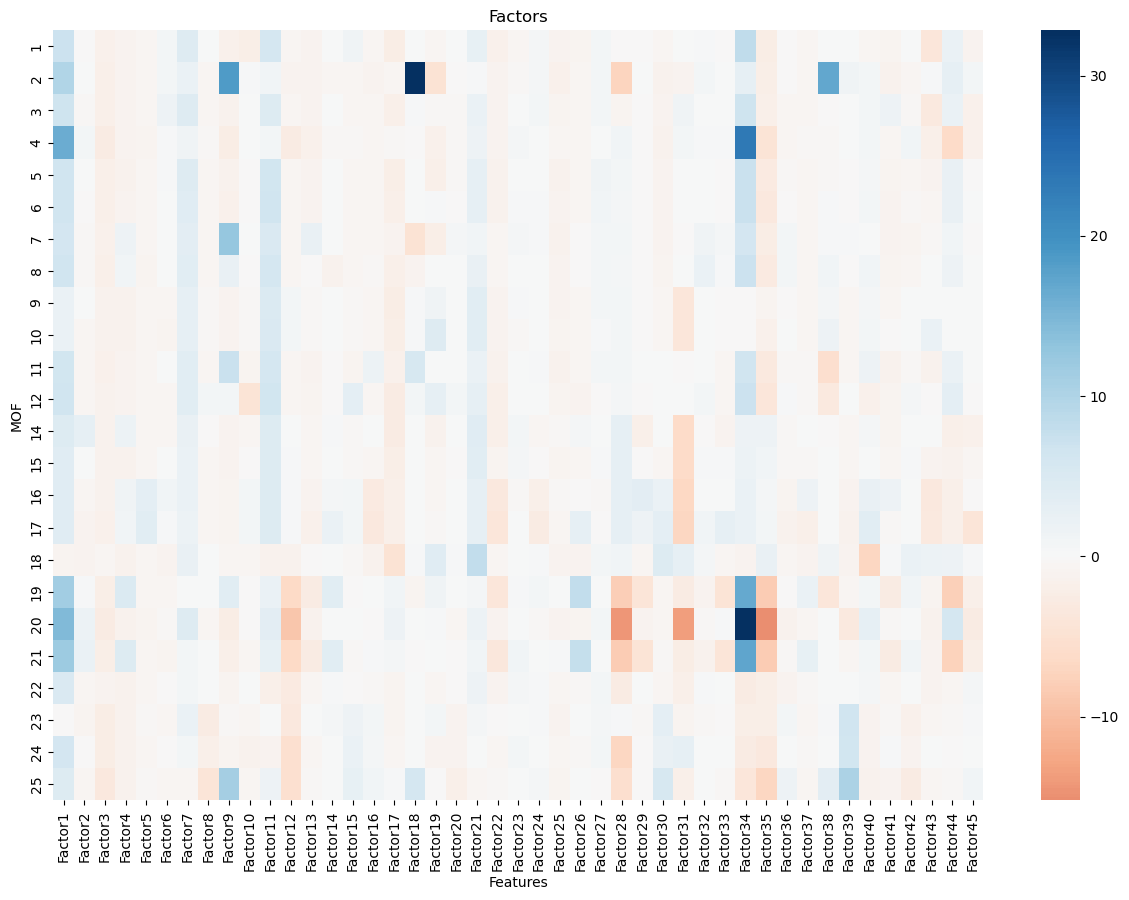

In [21]:
# feature visualization
plt.figure(figsize=(15, 10))
sns.heatmap(factor_scores_dfX, cmap='RdBu', center = 0, annot=False)
plt.title('Factors')
plt.xlabel('Features')
plt.ylabel('MOF')
plt.show()

In [22]:
print(df_standardized.shape)
print(dfX_standardized.shape)
print(factor_score_coefficients.T.shape)

(472494, 171)
(24, 171)
(171, 45)


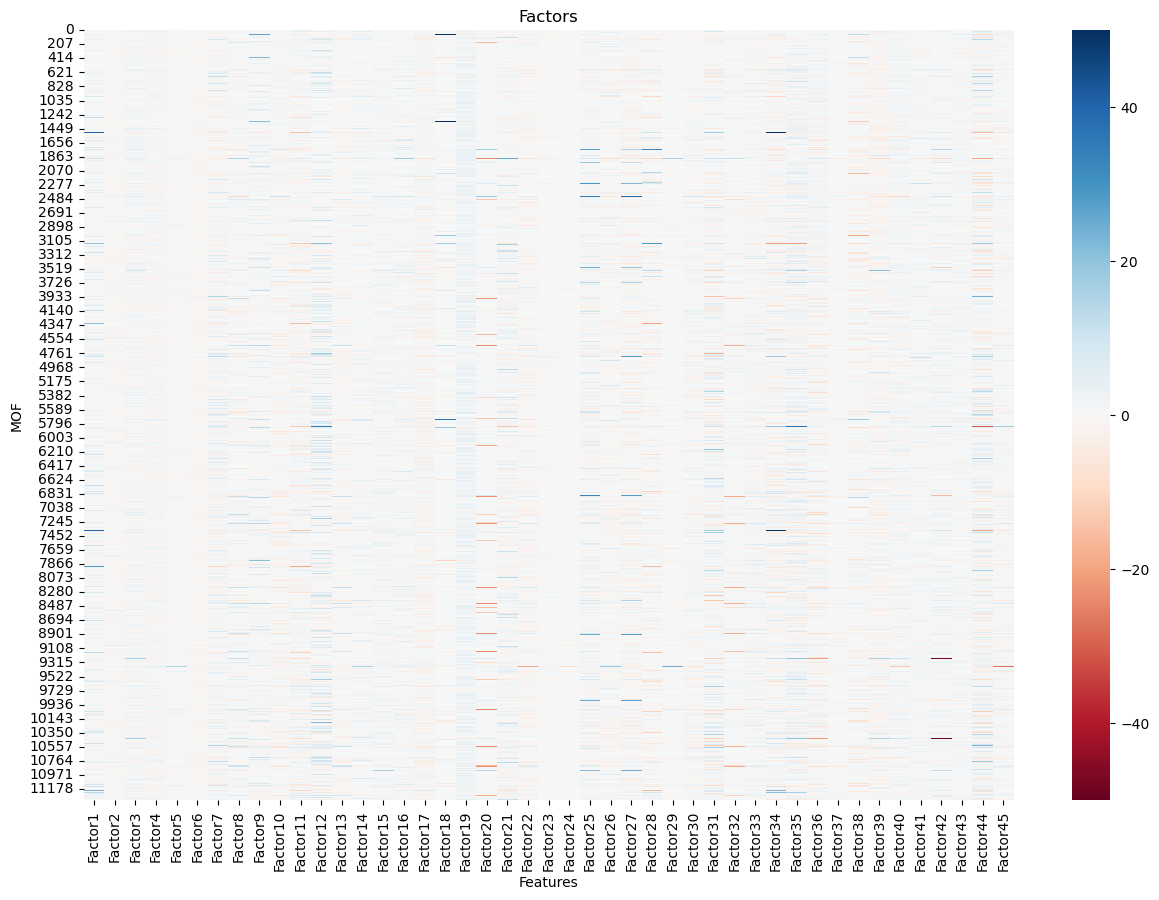

In [23]:
# EMOF visualization
plt.figure(figsize=(15, 10))
sns.heatmap(factor_scores_dfEMOF, cmap='RdBu', center = 0, annot=False, vmin=-50, vmax=50)
plt.title('Factors')
plt.xlabel('Features')
plt.ylabel('MOF')
plt.show()

In [24]:
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
import pandas as pd

# Assuming `df` is your DataFrame with the data to be analyzed

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data to standardize it

standardized_allMOF = scaler.fit_transform(factor_scores_df)
standardized_allMOF = pd.DataFrame(standardized_allMOF, columns=factor_scores_df.columns)     #all MOFs

standardized_data = scaler.fit_transform(factor_scores_dfX)
standardized_data = pd.DataFrame(standardized_data, columns=factor_scores_dfX.columns)     #MOFs used in this study

# transformation_matrix = np.linalg.pinv(factor_scores_dfX_removestd_2)@standardized_data
standardized_EMOF = scaler.transform(factor_scores_dfEMOF)
standardized_EMOF = pd.DataFrame(standardized_EMOF, columns=factor_scores_dfX.columns)     # for MOFs experimentally available

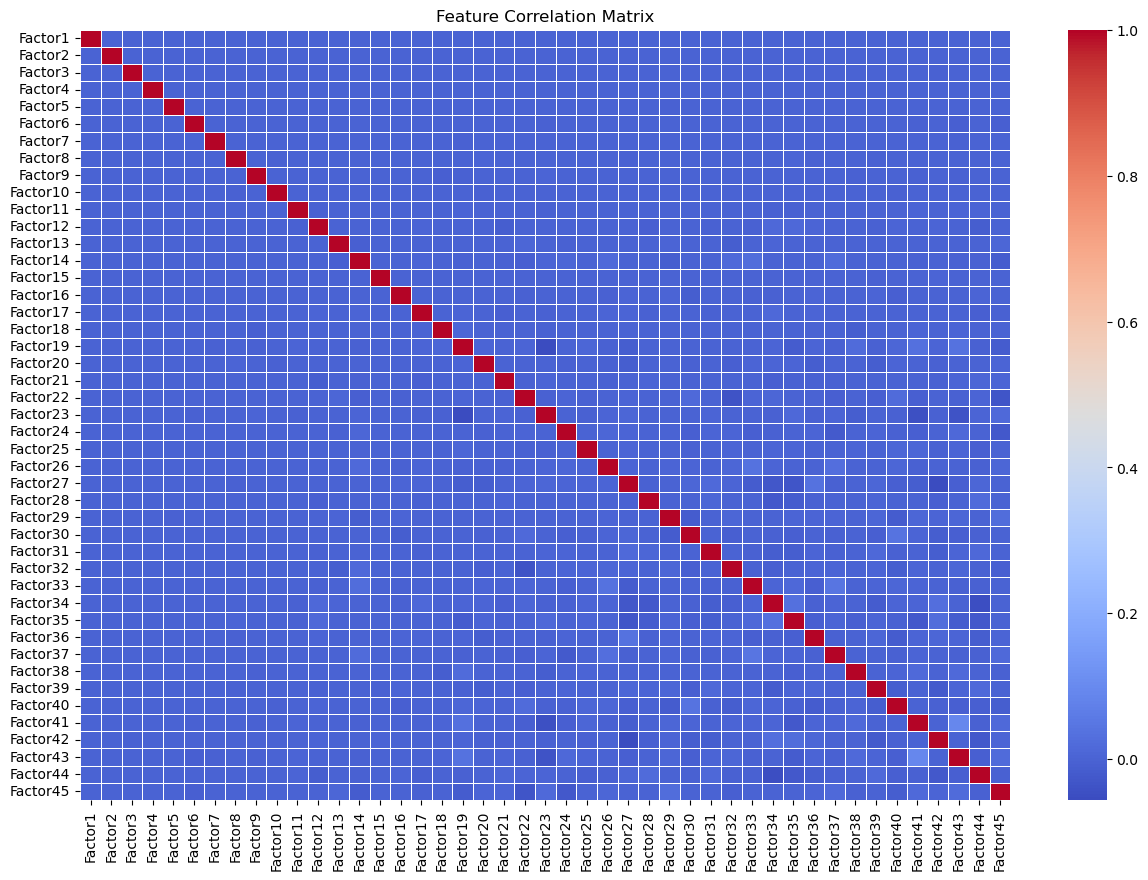

In [25]:
#check for correlation in these parameters
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the 14 data points and 55 features

# Calculate the correlation matrix
corr_matrix = standardized_allMOF.corr()

# Visualize the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5, annot=False)
plt.title('Feature Correlation Matrix')
plt.show()

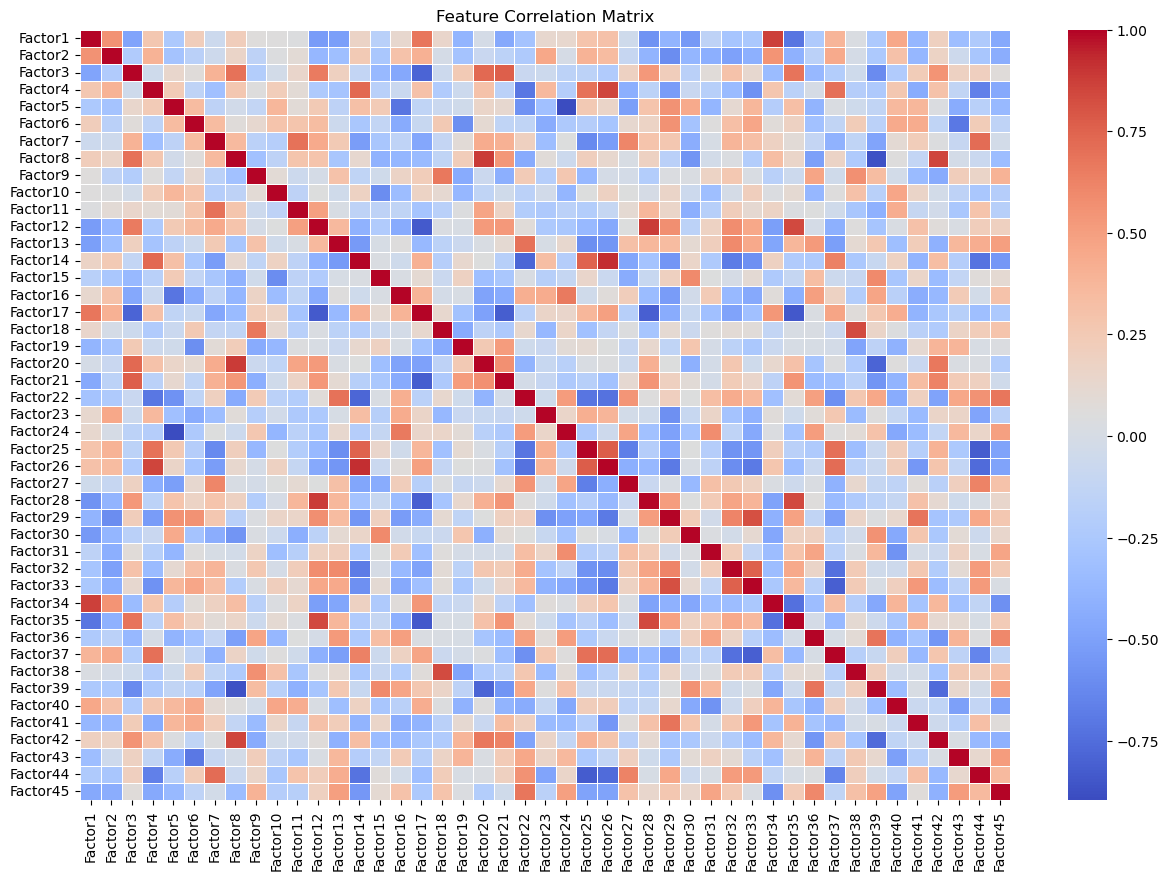

In [26]:
#check for correlation in these parameters

# Assuming 'df' is your DataFrame containing the 14 data points and 55 features

# Calculate the correlation matrix
corr_matrix = standardized_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5, annot=False)
plt.title('Feature Correlation Matrix')
plt.show()


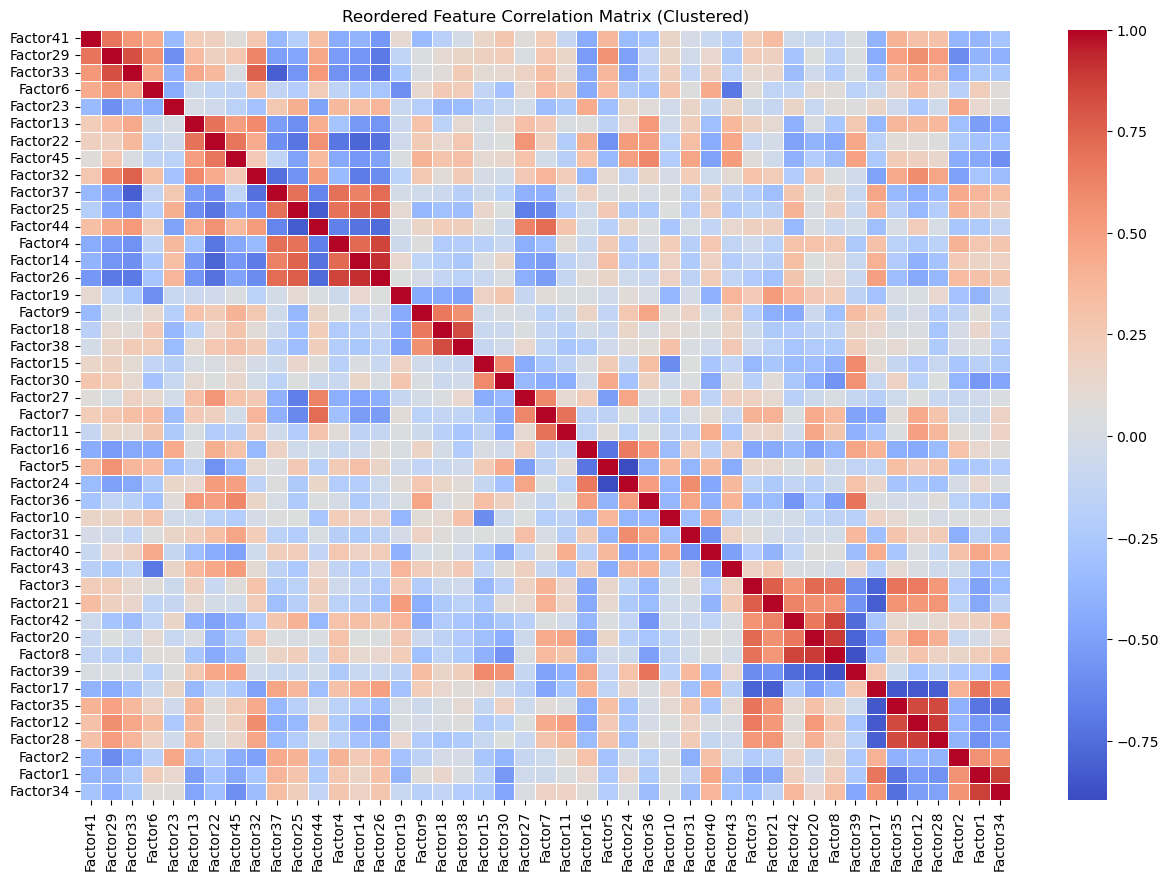

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

# Assuming 'standardized_data' is your DataFrame containing standardized features

# Step 1: Calculate the correlation matrix
corr_matrix = standardized_data.corr()

# Step 2: Reorder correlation matrix to cluster positive and negative correlations together
# Perform hierarchical clustering on correlation matrix
linkage_matrix = linkage(np.abs(corr_matrix), method='ward')
ordered_indices = leaves_list(linkage_matrix)

# Reorder the correlation matrix
df_reordered = corr_matrix.iloc[ordered_indices, ordered_indices]

# Step 3: Visualize the reordered correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(df_reordered, cmap='coolwarm', linewidths=0.5, annot=False)
plt.title('Reordered Feature Correlation Matrix (Clustered)')
plt.show()


In [28]:
reordered_standardized_data = standardized_data.iloc[:,ordered_indices]
reordered_standardized_data

,Factor41,Factor29,Factor33,Factor6,Factor23,Factor13,Factor22,Factor45,Factor32,Factor37,...,Factor20,Factor8,Factor39,Factor17,Factor35,Factor12,Factor28,Factor2,Factor1,Factor34
0,-0.351303,0.198808,0.116083,1.333363,-1.827990,-0.277465,-0.127591,-0.341433,0.303038,-0.386522,...,0.492045,0.704067,-0.203380,-0.746623,0.168060,0.449622,0.270239,-0.106722,0.183100,0.253046
1,-0.836391,0.355030,0.445251,1.450620,-1.576603,-0.371673,0.495913,1.155149,0.698306,-0.238130,...,-0.181877,-0.133867,0.280773,0.570779,0.214363,0.245227,-1.319027,0.128720,0.889890,-0.335411
2,2.449818,0.201745,0.234364,2.293287,-0.182487,-0.305634,0.170899,-0.864892,-0.036695,-0.551710,...,-0.229699,0.060771,-0.103319,-0.400270,0.298630,0.548483,0.120906,-0.284042,0.141618,0.085495
3,0.042389,0.107742,0.519276,0.558431,0.789789,-0.778822,0.187206,-0.912314,0.064909,-0.086860,...,-0.293254,0.336518,-0.181226,0.773041,-0.390405,-0.228250,0.585988,0.690829,2.451856,2.023397
4,-0.257211,0.128665,0.180480,0.669615,0.043446,-0.186508,0.067442,0.383906,-0.124342,-0.258657,...,-0.245392,-0.050956,-0.233578,-0.600730,0.017357,0.461854,0.487026,0.255552,0.093117,0.140221
5,-0.417816,0.160094,0.049910,0.010936,0.221852,-0.201638,0.002803,0.443738,-0.157265,-0.405828,...,0.045043,0.033768,-0.284203,-0.499437,-0.117270,0.491079,0.475442,-0.230994,0.083451,0.148002
6,-0.557417,0.096732,0.657135,0.381482,0.594701,3.386003,0.853713,0.285099,1.490134,-0.443407,...,1.333266,-0.016361,-0.049283,0.088234,0.177353,0.521178,0.480862,-0.371370,-0.058498,-0.006525
7,-0.209729,0.148347,0.508999,0.057611,-0.041053,0.705189,0.905153,0.695549,2.476357,-0.440292,...,0.366121,0.133783,-0.246695,-0.421185,-0.010841,0.501967,0.462578,-0.423229,0.053194,0.103508
8,-0.191974,0.168033,0.146636,-0.790655,0.463990,0.426072,0.452590,0.483089,-0.053564,-0.258696,...,0.315790,0.227676,-0.422857,-0.736122,0.557853,1.041967,0.557172,-0.049544,-0.981290,-0.720480
9,0.456152,0.211253,0.072445,-1.187065,-1.704231,0.401622,0.385243,0.640666,-0.018615,-0.332613,...,0.617389,0.314846,-0.470591,-0.611978,0.380393,1.070613,0.547468,-0.555028,-0.991718,-0.710106


In [29]:
dfNi = pd.read_csv(r'./20_MOFs_Ni_new.csv')

In [30]:
dfNi

,MOF_index,MOF,Yield_mean,Selectivity_mean,Yield_1,Yield_2,Selectivity_1,Selectivity_2,Structure_integrity_after_rxn,Ni_M_ratio
0,1,MOF-808,0.8850,0.9780,0.890,0.880,0.972,0.984,1,0.510
1,2,MOF-808-BA,0.1400,0.9990,0.150,0.130,0.998,1.000,1,0.510
2,3,MOF-808-W,0.7400,0.7890,0.770,0.710,0.770,0.808,1,0.510
3,4,Zr12-BPDC,0.7000,0.6800,0.720,0.680,0.678,0.682,1,0.270
4,5,UiO-67,0.5350,0.6335,0.600,0.470,0.663,0.604,1,0.230
5,6,UiO-66,0.5400,0.8480,0.550,0.530,0.857,0.839,1,0.100
6,7,UiO-66-NH2,0.4500,0.8840,0.490,0.410,0.870,0.898,1,0.100
7,8,UiO-66-OH,0.4000,0.8765,0.410,0.390,0.898,0.855,1,0.100
8,9,MIL-140-BPDC,0.0600,0.7490,0.070,0.050,0.797,0.701,1,0.510
9,10,MIL-140-BDC,0.0600,0.0520,0.070,0.050,0.023,0.081,1,0.060


In [31]:
# import os
# from sklearn.manifold import TSNE
# import umap

# # Apply tSNE for dimensionality reduction and visualization
# tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
# tsne_results = tsne.fit_transform(standardized_EMOF)

# # Apply UMAP for an alternative visualization
# reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
# umap_results = reducer.fit_transform(standardized_EMOF)

# # Convert the results into a DataFrame and add the metal type information
# df_tsne = pd.DataFrame(tsne_results, columns=['tSNE1', 'tSNE2'])
# # df_tsne['Metal'] = filtered_mofs_df['Metal']

# df_umap = pd.DataFrame(umap_results, columns=['UMAP1', 'UMAP2'])
# # df_umap['Metal'] = filtered_mofs_df['Metal']

# # Overlaying experimental data onto the UMAP plot
# dfX_umap = reducer.transform(standardized_data)
# dfX_umap = pd.DataFrame(dfX_umap, columns=['UMAP1', 'UMAP2'])
# dfX_umap['Yield'] = dfNi['Yield_mean']  # Example: replace with actual yield data
# dfX_umap['Selectivity'] = dfNi['Selectivity_mean']  # Example: replace with actual selectivity data

# # Visualize UMAP results with different colors
# plt.figure(figsize=(10, 8))
# sns.scatterplot(x='UMAP1', y='UMAP2', data=df_umap, legend=None, color='lightgrey', edgecolor=None)
# sns.scatterplot(x='UMAP1', y='UMAP2', hue='Selectivity', size='Yield', data=dfX_umap, palette='coolwarm', sizes=(20, 200))
# plt.xlabel('UMAP Component 1',fontsize=15)
# plt.ylabel('UMAP Component 2',fontsize=15)
# plt.title('UMAP Projection with Experimental Data Overlay',fontsize=15)
# plt.show()

Trial: 0
Model: LogisticRegression
Selected Features: ['Factor1', 'Factor4', 'Factor5', 'Factor6', 'Factor15', 'Factor19', 'Factor23', 'Factor27', 'Factor28', 'Factor30', 'Factor43']
Test Accuracy: 1.0
Test F1 Score: 1.0
Model: DecisionTree
Selected Features: ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'Factor6', 'Factor7', 'Factor8', 'Factor9', 'Factor10', 'Factor11', 'Factor12', 'Factor13', 'Factor14', 'Factor15', 'Factor16', 'Factor17', 'Factor18', 'Factor19', 'Factor20', 'Factor21', 'Factor22', 'Factor25', 'Factor26', 'Factor27', 'Factor28', 'Factor29', 'Factor30', 'Factor31', 'Factor32', 'Factor33', 'Factor34', 'Factor35', 'Factor36', 'Factor37', 'Factor38', 'Factor39', 'Factor40', 'Factor41', 'Factor42', 'Factor43', 'Factor44', 'Factor45', 'stability', 'Ni_M_ratio']
Test Accuracy: 1.0
Test F1 Score: 1.0
Model: RandomForest
Selected Features: ['Factor1', 'Factor2', 'Factor5', 'Factor6', 'Factor14', 'Factor15', 'Factor17', 'Factor19', 'Factor20', 'Factor21', 'Factor22',

c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor19', 'Factor27', 'Factor30']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: DecisionTree
Selected Features: ['Factor27', 'Factor40', 'Factor42', 'Factor43', 'Factor44', 'Factor45', 'stability', 'Ni_M_ratio']
Test Accuracy: 0.0
Test F1 Score: 0.0
Model: RandomForest
Selected Features: ['Factor1', 'Factor2', 'Factor5', 'Factor6', 'Factor7', 'Factor8', 'Factor9', 'Factor10', 'Factor14', 'Factor15', 'Factor16', 'Factor17', 'Factor18', 'Factor19', 'Factor20', 'Factor21', 'Factor22', 'Factor23', 'Factor24', 'Factor25', 'Factor26', 'Factor27', 'Factor29', 'Factor30', 'Factor33', 'Factor35', 'Factor38', 'Factor39', 'Factor41', 'Ni_M_ratio']
Test Accuracy: 0.0
Test F1 Score: 0.0
Trial: 10
Model: LogisticRegression
Selected Features: ['Factor19', 'Factor27', 'Factor30']
Test Accuracy: 1.0
Test F1 Score: 1.0
Model: DecisionTree
Selected Features: ['Factor27', 'Factor42', 'Factor43', 'Factor44', 'Factor45', 'stability', 'Ni_M_ratio']
Test Accuracy: 0.0
Test F1 Score: 0.0
M

c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor6', 'Factor27', 'Factor30']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: DecisionTree
Selected Features: ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'Factor6', 'Factor7', 'Factor8', 'Factor38', 'Factor39', 'Factor40', 'Factor41', 'Factor42', 'Factor43', 'Factor44', 'Factor45']
Test Accuracy: 0.0
Test F1 Score: 0.0
Model: RandomForest


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor1', 'Factor2', 'Factor5', 'Factor6', 'Factor7', 'Factor14', 'Factor19', 'Factor21', 'Factor26', 'Factor27', 'Factor30', 'Factor34']
Test Accuracy: 1.0
Test F1 Score: 0.0
Trial: 12
Model: LogisticRegression
Selected Features: ['Factor19', 'Factor27', 'Factor30']
Test Accuracy: 0.0
Test F1 Score: 0.0
Model: DecisionTree
Selected Features: ['Factor2', 'Factor23']
Test Accuracy: 0.0
Test F1 Score: 0.0
Model: RandomForest
Selected Features: ['Factor1', 'Factor2', 'Factor5', 'Factor6', 'Factor7', 'Factor8', 'Factor9', 'Factor13', 'Factor14', 'Factor15', 'Factor16', 'Factor19', 'Factor20', 'Factor21', 'Factor22', 'Factor23', 'Factor25', 'Factor26', 'Factor27', 'Factor30', 'Factor33', 'Factor35', 'Factor40', 'Factor41', 'Ni_M_ratio']
Test Accuracy: 0.0
Test F1 Score: 0.0
Trial: 13
Model: LogisticRegression
Selected Features: ['Factor1', 'Factor4', 'Factor5', 'Factor6', 'Factor15', 'Factor19', 'Factor23', 'Factor25', 'Factor27', 'Factor28', 'Factor30', 'Factor31', 'Fa

c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor19', 'Factor27', 'Factor30']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: DecisionTree


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor3', 'Factor4', 'Factor5', 'Factor6', 'Factor7', 'Factor8', 'Factor9', 'Factor10', 'Factor11', 'Factor12', 'Factor13', 'Factor14', 'Factor15', 'Factor16', 'Factor17', 'Factor18', 'Factor19', 'Factor20', 'Factor21', 'Factor22', 'Factor23', 'Factor24', 'Factor25', 'Factor26', 'Factor27', 'Factor28', 'Factor29', 'Factor30', 'Factor31', 'Factor32', 'Factor33', 'Factor34', 'Factor35', 'Factor36', 'Factor37', 'Factor38', 'Factor39', 'Factor40', 'Factor41', 'Factor42', 'Factor43', 'Factor44', 'Factor45', 'stability', 'Ni_M_ratio']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: RandomForest


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor1', 'Factor2', 'Factor5', 'Factor6', 'Factor19', 'Factor20', 'Factor26', 'Factor27', 'Factor30']
Test Accuracy: 1.0
Test F1 Score: 0.0
Trial: 15
Model: LogisticRegression


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor19', 'Factor27', 'Factor30']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: DecisionTree


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor3', 'Factor4', 'Factor5', 'Factor6', 'Factor7', 'Factor8', 'Factor9', 'Factor10', 'Factor11', 'Factor12', 'Factor13', 'Factor14', 'Factor15', 'Factor16', 'Factor17', 'Factor18', 'Factor19', 'Factor20', 'Factor21', 'Factor22', 'Factor23', 'Factor24', 'Factor25', 'Factor26', 'Factor27', 'Factor28', 'Factor29', 'Factor30', 'Factor31', 'Factor32', 'Factor33', 'Factor34', 'Factor35', 'Factor36', 'Factor37', 'Factor38', 'Factor39', 'Factor40', 'Factor41', 'Factor42', 'Factor43', 'Factor44', 'Factor45', 'stability', 'Ni_M_ratio']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: RandomForest


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor1', 'Factor2', 'Factor5', 'Factor6', 'Factor12', 'Factor13', 'Factor15', 'Factor17', 'Factor19', 'Factor20', 'Factor21', 'Factor26', 'Factor27', 'Factor29', 'Factor30', 'Factor33', 'Factor34', 'Factor39', 'Factor43', 'Ni_M_ratio']
Test Accuracy: 1.0
Test F1 Score: 0.0
Trial: 16
Model: LogisticRegression
Selected Features: ['Factor27']
Test Accuracy: 0.0
Test F1 Score: 0.0
Model: DecisionTree
Selected Features: ['Factor27']
Test Accuracy: 0.0
Test F1 Score: 0.0
Model: RandomForest


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor5', 'Factor6', 'Factor27']
Test Accuracy: 1.0
Test F1 Score: 0.0
Trial: 17
Model: LogisticRegression
Selected Features: ['Factor1', 'Factor27', 'Factor30']
Test Accuracy: 0.0
Test F1 Score: 0.0
Model: DecisionTree


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor5']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: RandomForest
Selected Features: ['Factor1', 'Factor2', 'Factor5', 'Factor6', 'Factor10', 'Factor14', 'Factor15', 'Factor16', 'Factor19', 'Factor20', 'Factor21', 'Factor23', 'Factor26', 'Factor27', 'Factor30', 'Factor34', 'Factor35', 'Factor38', 'Factor39', 'Factor40', 'Ni_M_ratio']
Test Accuracy: 0.0
Test F1 Score: 0.0
Trial: 18
Model: LogisticRegression
Selected Features: ['Factor1', 'Factor19', 'Factor27', 'Factor30']
Test Accuracy: 1.0
Test F1 Score: 1.0
Model: DecisionTree
Selected Features: ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'Factor6', 'Factor7', 'Factor8', 'Factor9', 'Factor10', 'Factor11', 'Factor12', 'Factor27', 'Factor28', 'Factor29', 'Factor30', 'Factor31', 'Factor32', 'Factor33', 'Factor34', 'Factor35', 'Factor36', 'Factor37', 'Factor38', 'Factor39']
Test Accuracy: 1.0
Test F1 Score: 1.0
Model: RandomForest
Selected Features: ['Factor1', 'Factor2', 'Factor5', 'Factor6', 'Factor9'

c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor19', 'Factor27', 'Factor30']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: DecisionTree
Selected Features: ['Factor16', 'Factor17', 'Factor18', 'Factor19', 'Factor20', 'Factor21', 'Factor22', 'Factor23', 'Factor24', 'Factor25', 'Factor26', 'Factor27', 'Factor28', 'Factor29', 'Factor30', 'Factor31', 'Factor32', 'Factor33', 'Factor34', 'Factor35', 'Factor36', 'Factor37', 'Factor38', 'Factor39', 'Factor40', 'Factor41', 'Factor42', 'Factor43', 'Factor44', 'Factor45', 'stability', 'Ni_M_ratio']
Test Accuracy: 0.0
Test F1 Score: 0.0
Model: RandomForest
Selected Features: ['Factor5', 'Factor6', 'Factor20', 'Factor21', 'Factor27', 'Factor30']
Test Accuracy: 0.0
Test F1 Score: 0.0
Trial: 22
Model: LogisticRegression
Selected Features: ['Factor19', 'Factor27', 'Factor30']
Test Accuracy: 1.0
Test F1 Score: 1.0
Model: DecisionTree
Selected Features: ['Factor5', 'Factor19']
Test Accuracy: 0.0
Test F1 Score: 0.0
Model: RandomForest
Selected Features: ['Factor1', 'Factor2', 

c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor19', 'Factor27', 'Factor30']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: DecisionTree


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'Factor6', 'Factor7', 'Factor8', 'Factor9', 'Factor10', 'Factor11', 'Factor12', 'Factor13', 'Factor14', 'Factor15', 'Factor16', 'Factor17', 'Factor18', 'Factor19', 'Factor20', 'Factor21', 'Factor22', 'Factor25', 'Factor26', 'Factor27', 'Factor28', 'Factor29', 'Factor30', 'Factor31', 'Factor32', 'Factor33', 'Factor34', 'Factor35', 'Factor36', 'Factor37', 'Factor38', 'Factor39', 'Factor40', 'Factor41', 'Factor42', 'Factor43', 'Factor44', 'Factor45', 'stability', 'Ni_M_ratio']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: RandomForest
Selected Features: ['Factor1', 'Factor2', 'Factor5', 'Factor6', 'Factor8', 'Factor12', 'Factor14', 'Factor15', 'Factor16', 'Factor17', 'Factor19', 'Factor20', 'Factor21', 'Factor22', 'Factor23', 'Factor24', 'Factor25', 'Factor26', 'Factor27', 'Factor29', 'Factor30', 'Factor32', 'Factor33', 'Factor35', 'Factor39', 'Factor41', 'Factor44']
Test Accuracy: 0.0
Test F1 Score: 0.0


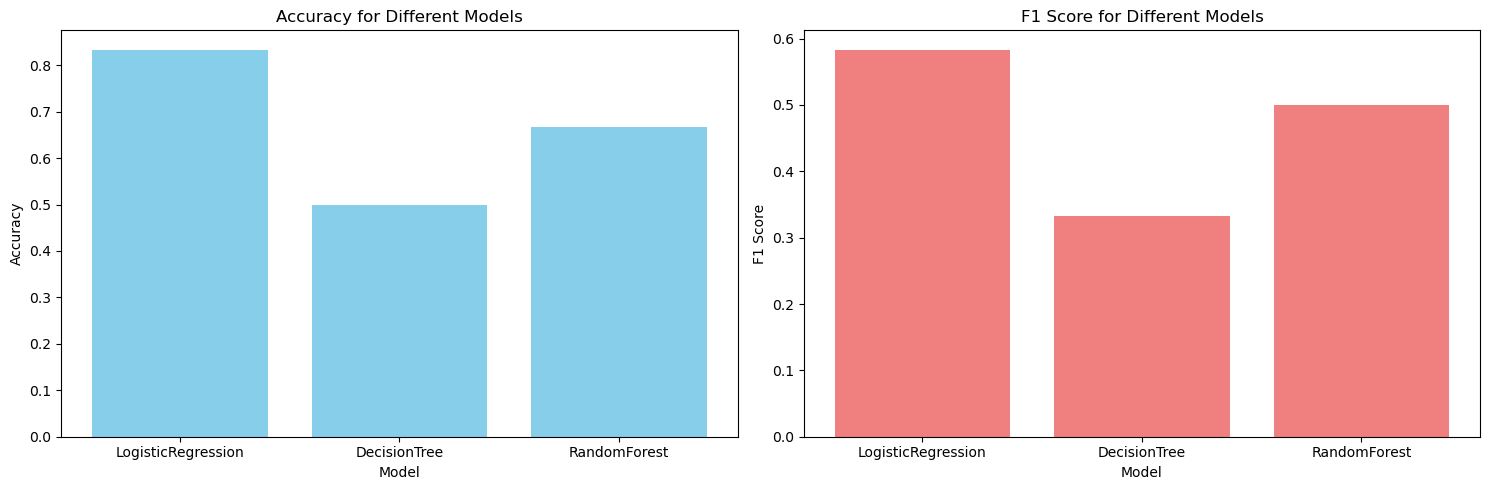

In [32]:
#sp3 activity, classification

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Data preparation (Assuming dfNi and standardized_data are already defined)
X_select = []
y = []
indexes = []
for i in dfNi.index:
    indexes.append(i)
    X_select.append(list(standardized_data.iloc[i].values) + [
            dfNi['Structure_integrity_after_rxn'].iloc[i],
            dfNi['Ni_M_ratio'].iloc[i]
        ])
    if not pd.isna(dfNi['Selectivity_1'].iloc[i]):
        y.append((dfNi['Yield_1'].iloc[i] * (dfNi['Selectivity_1'].iloc[i]) +
                  dfNi['Yield_2'].iloc[i] * (dfNi['Selectivity_2'].iloc[i])) / 2)
    else:
        y.append(0)

X_select = pd.DataFrame(X_select, index=indexes,
                        columns=list(standardized_data.columns) + ['stability', 'Ni_M_ratio'])

# Binarize y based on the median value
y_median = 0.025
y = [1 if value > y_median else 0 for value in y]
y = pd.DataFrame(y, index=indexes, columns=['Class'])

# Define the number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
num_sample = len(np.unique(indexes))

# Store selected predictors
Selected_Factors = [[] for _ in range(num_sample)]
Accuracies = [[] for _ in range(num_sample)]
F1s = [[] for _ in range(num_sample)]

# Different models to try
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}

trial_num = 0
for index in np.unique(indexes):
    print('Trial:', trial_num)
    # Build the LOO dataset by removing the current group
    X_train_val = X_select.drop([index])
    y_train_val = y.drop([index])
    X_test = X_select.loc[[index]]
    y_test = y.loc[[index]]

    for model_name, model in models.items():
        print(f"Model: {model_name}")

        # Recursive Feature Elimination with Cross-Validation for feature selection
        selector = RFECV(estimator=model, step=1, cv=kf, scoring='accuracy')
        selector = selector.fit(X_train_val, y_train_val.values.flatten())
        selected_features = X_train_val.columns[selector.support_]

        # Fit the model with selected features
        model.fit(X_train_val[selected_features], y_train_val.values.flatten())

        # Predictions for the test set
        y_pred_test = model.predict(X_test[selected_features])

        # Evaluation metrics for test set
        acc_test = accuracy_score(y_test, y_pred_test)
        f1_test = f1_score(y_test, y_pred_test)

        # Store metrics
        Accuracies[trial_num].append(acc_test)
        F1s[trial_num].append(f1_test)

        # Output performance
        print('Selected Features:', selected_features.tolist())
        print(f"Test Accuracy: {acc_test}")
        print(f"Test F1 Score: {f1_test}")

        Selected_Factors[trial_num].append(selected_features.tolist())

    trial_num += 1

# Visualization of Accuracy and F1 metrics
models_list = list(models.keys())
accuracy_values = np.mean(Accuracies, axis=0)
f1_values = np.mean(F1s, axis=0)

plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.bar(models_list, accuracy_values, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Models')

# F1 Score plot
plt.subplot(1, 2, 2)
plt.bar(models_list, f1_values, color='lightcoral')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score for Different Models')

plt.tight_layout()
plt.show()


In [33]:
import numpy as np
from collections import Counter

# Assuming df_reordered is the DataFrame containing factor correlations and 'factor_counter' is already defined
threshold = 0.80 # Set the correlation threshold

# Step 1: Group factors ensuring all pairs within the group have correlation above the threshold
factor_groups = []
visited = set()

for i in df_reordered.columns:
    if i in visited:
        continue
    # Start a candidate group with factor 'i'
    candidate_group = [i]
    for j in df_reordered.columns:
        if j in visited or i == j:
            continue
        # Check if 'j' can be added to the candidate group (i.e., it meets the correlation threshold with all existing members)
        if all(abs(df_reordered.loc[factor, j]) >= threshold for factor in candidate_group):
            candidate_group.append(j)
            visited.add(j)
    visited.add(i)
    # Add the candidate group to the list
    factor_groups.append(candidate_group)

# Step 2: Compute factor frequency based on unique groups to avoid double counting
factor_counter_groupwise = Counter()
factor_accuracy_groupwise = {}

# Count occurrences and accumulate accuracy values without double counting within each entry
for i in range(len(Selected_Factors)):
    for factors, acc in zip(Selected_Factors[i], Accuracies[i]):
        if isinstance(factors, list):  # Ensure factors is a list before iterating
            counted_groups = set()
            for group in factor_groups:
                # Check if any factors in the group are present in the current list of factors
                group_factors_in_entry = [factor for factor in factors if factor in group]
                if group_factors_in_entry:
                    # Only count the first occurrence in the group to avoid double counting within the entry
                    first_factor = group_factors_in_entry[0]
                    if tuple(group) not in counted_groups:
                        factor_counter_groupwise[first_factor] += 1
                        if first_factor in factor_accuracy_groupwise:
                            factor_accuracy_groupwise[first_factor].append(acc)
                        else:
                            factor_accuracy_groupwise[first_factor] = [acc]
                        counted_groups.add(tuple(group))

# Calculate average accuracy for each factor without double counting
factor_avg_accuracy_groupwise = {factor: np.mean(accs) for factor, accs in factor_accuracy_groupwise.items()}

# Step 3: Sum the factor frequencies within each group ensuring no double counting within each group
grouped_factor_counter = {}

for group in factor_groups:
    # Create a name for the group by joining factor names with their individual frequencies
    group_name = " & ".join(f"{factor}({factor_counter_groupwise[factor]})" for factor in group)
    grouped_count = sum(factor_counter_groupwise[factor] for factor in group)
    grouped_factor_counter[group_name] = grouped_count

# Step 4: Output the grouped factors with their summed frequencies, sorted by frequency in descending order
print("\nGrouped Factors with Summed Frequencies and Average Accuracy (Sorted by Frequency):")
for group, count in sorted(grouped_factor_counter.items(), key=lambda x: x[1], reverse=True):
    avg_accuracy = np.mean(
        [factor_avg_accuracy_groupwise[factor] for factor in group.split(" & ") if factor in factor_avg_accuracy_groupwise]
    )
    print(f"{group}: Frequency = {count}, Avg Accuracy = {avg_accuracy:.4f}")



Grouped Factors with Summed Frequencies and Average Accuracy (Sorted by Frequency):
Factor27(67): Frequency = 67, Avg Accuracy = nan
Factor30(56): Frequency = 56, Avg Accuracy = nan
Factor19(50): Frequency = 50, Avg Accuracy = nan
Factor5(47) & Factor24(2): Frequency = 49, Avg Accuracy = nan
Factor1(42) & Factor34(7): Frequency = 49, Avg Accuracy = nan
Factor6(45): Frequency = 45, Avg Accuracy = nan
Factor4(23) & Factor26(16): Frequency = 39, Avg Accuracy = nan
Factor15(31): Frequency = 31, Avg Accuracy = nan
Factor35(4) & Factor12(16) & Factor28(11): Frequency = 31, Avg Accuracy = nan
Factor20(28): Frequency = 28, Avg Accuracy = nan
Factor43(27): Frequency = 27, Avg Accuracy = nan
Factor2(27): Frequency = 27, Avg Accuracy = nan
Factor23(26): Frequency = 26, Avg Accuracy = nan
Factor21(8) & Factor17(18): Frequency = 26, Avg Accuracy = nan
Factor14(24): Frequency = 24, Avg Accuracy = nan
Factor29(17) & Factor33(6): Frequency = 23, Avg Accuracy = nan
Factor42(5) & Factor8(18): Frequency

c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 58 seconds.
c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecatio

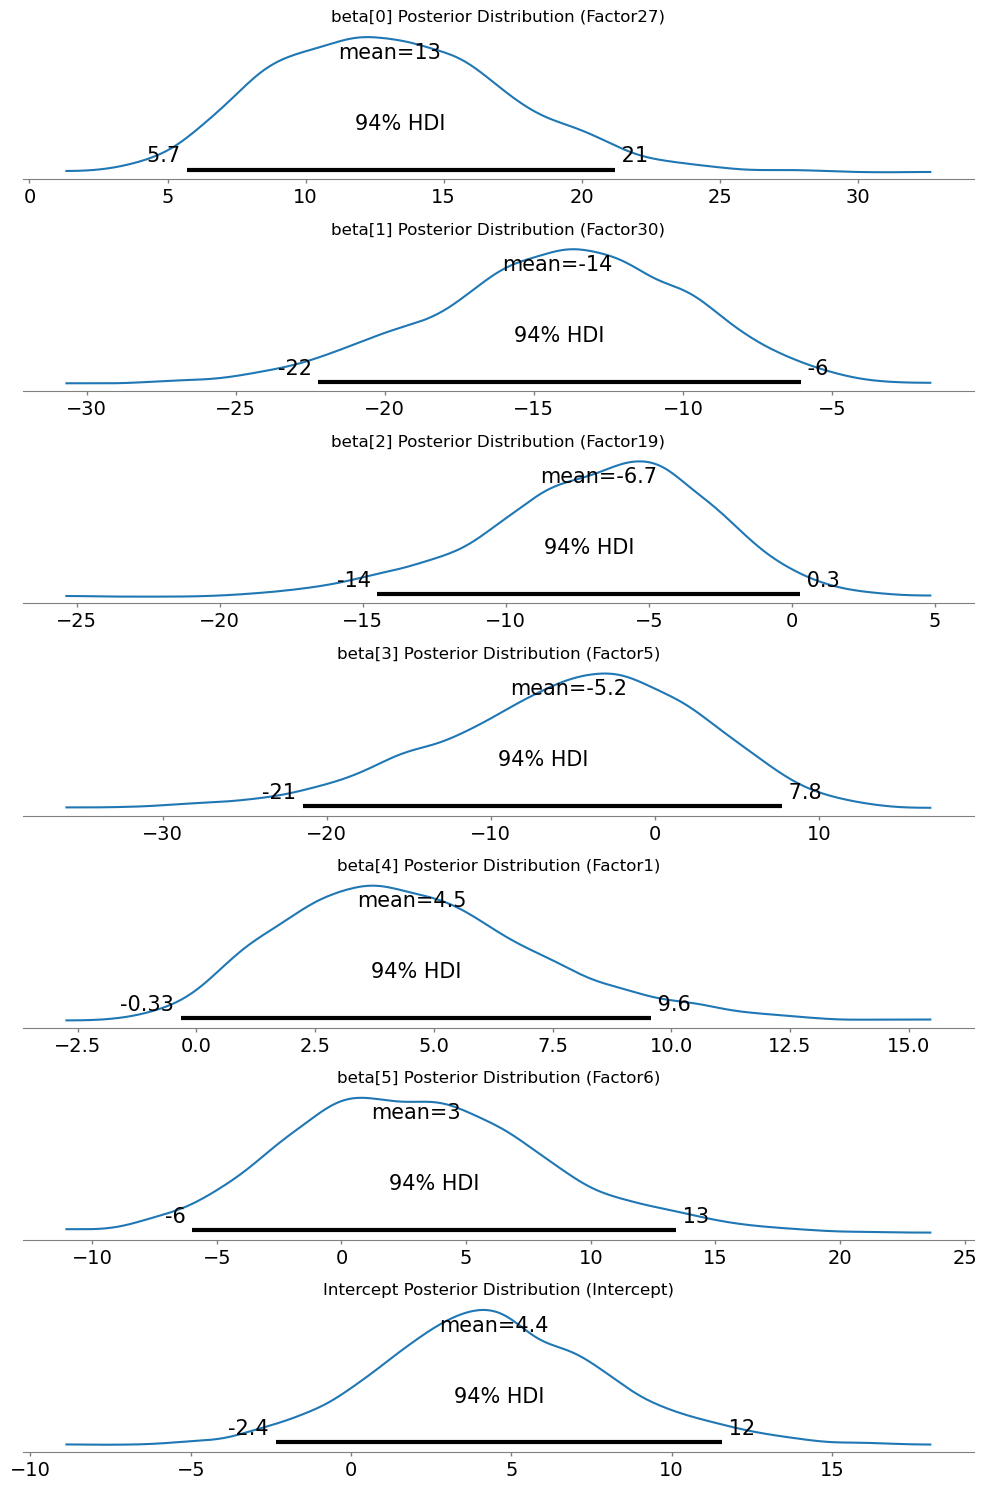

Sampling: [observed]


Accuracy: 0.9791666666666666
Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.95      0.97        19
        True       0.97      1.00      0.98        29

    accuracy                           0.98        48
   macro avg       0.98      0.97      0.98        48
weighted avg       0.98      0.98      0.98        48



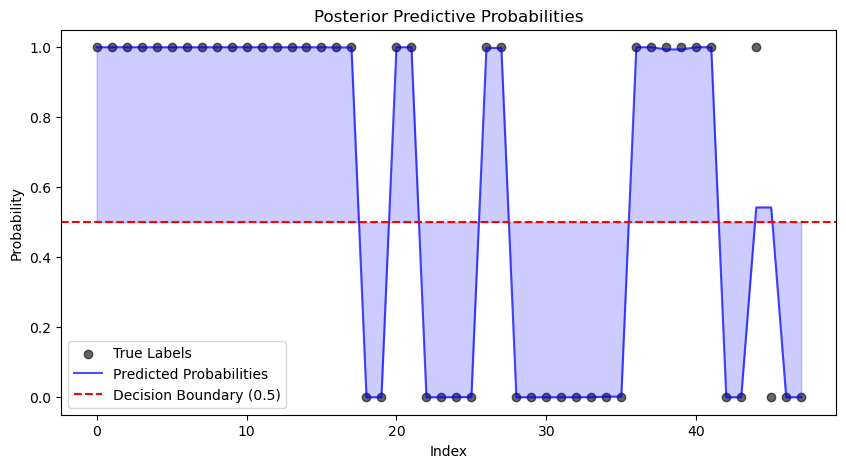

In [34]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
# classification
from sklearn.metrics import accuracy_score, classification_report

Selected_columns = ['Factor27', 'Factor30', 'Factor19', 'Factor5', 'Factor1', 'Factor6']

X_select = []
y = []
indexes = []
for i in dfNi.index:
    indexes.append(i)
    
    X_select.append(list(standardized_data.iloc[i].values) + [
            dfNi['Structure_integrity_after_rxn'].iloc[i],
            dfNi['Ni_M_ratio'].iloc[i]
        ])
    
    if not pd.isna(dfNi['Selectivity_1'].iloc[i]):
        y.append(dfNi['Yield_1'].iloc[i] * (dfNi['Selectivity_1'].iloc[i]) > y_median)
    else:
        y.append(False)
        
    indexes.append(i)
    
    X_select.append(list(standardized_data.iloc[i].values) + [
            dfNi['Structure_integrity_after_rxn'].iloc[i],
            dfNi['Ni_M_ratio'].iloc[i]
        ])
    
    if not pd.isna(dfNi['Selectivity_2'].iloc[i]):
        y.append(dfNi['Yield_2'].iloc[i] * (dfNi['Selectivity_2'].iloc[i]) > y_median)
    else:
        y.append(False)

X_select = pd.DataFrame(X_select, index=indexes, columns=list(standardized_data.columns) + ['stability', 'Ni_M_ratio'])
y = pd.DataFrame(y, index=indexes, columns=['Class'])

# feature selection
X_select = X_select[Selected_columns]

# Bayesian model
with pm.Model() as bayesian_logistic_model:
    # prior
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X_select.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # linear combo
    linear_combination = pm.math.dot(X_select.values, beta) + intercept
    
    # activation function
    p = pm.Deterministic("p", pm.math.sigmoid(linear_combination))
    
    # obs
    observed = pm.Bernoulli("observed", p=p, observed=y['Class'].values)
    
    # posterior
    trace = pm.sample(1000, tune=2000, target_accept=0.95, random_seed=42)


# varaibles
variable_names = X_select.columns.tolist()

fig, axes = plt.subplots(len(trace.posterior["beta"].values.T) + 1, 1, figsize=(10, 15))  # 每个参数一个子图
for i, ax in enumerate(axes[:-1]):
    az.plot_posterior(trace.posterior["beta"][:, :, i], ax=ax)
    
    ax.set_title(f"beta[{i}] Posterior Distribution ({variable_names[i]})")

# intercept
az.plot_posterior(trace.posterior["intercept"], ax=axes[-1])
axes[-1].set_title("Intercept Posterior Distribution (Intercept)")

plt.tight_layout()
plt.show()


with bayesian_logistic_model:
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
beta_samples = trace.posterior["beta"].mean(axis=(0, 1)).values
intercept_sample = trace.posterior["intercept"].mean(axis=(0, 1)).values

linear_combination = np.dot(X_select.values, beta_samples) + intercept_sample
pred_mean = 1 / (1 + np.exp(-linear_combination))  # Sigmoid
y_pred = (pred_mean > 0.5).astype(int)

accuracy = accuracy_score(y['Class'].values, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y['Class'].values, y_pred))


plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(y)), y['Class'], label="True Labels", alpha=0.6, color="black")
plt.plot(np.arange(len(y)), pred_mean, label="Predicted Probabilities", alpha=0.7, color="blue")
plt.axhline(0.5, linestyle="--", color="red", label="Decision Boundary (0.5)")
plt.fill_between(np.arange(len(y)), 0.5, pred_mean, alpha=0.2, color="blue")
plt.legend()
plt.xlabel("Index")
plt.ylabel("Probability")
plt.title("Posterior Predictive Probabilities")
plt.show()

<Figure size 800x600 with 0 Axes>

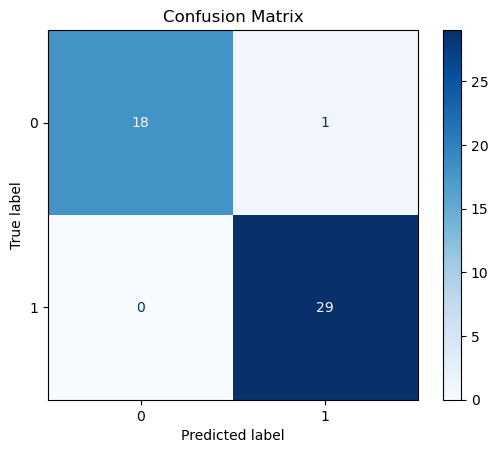

In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y['Class'].values, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 36 seconds.


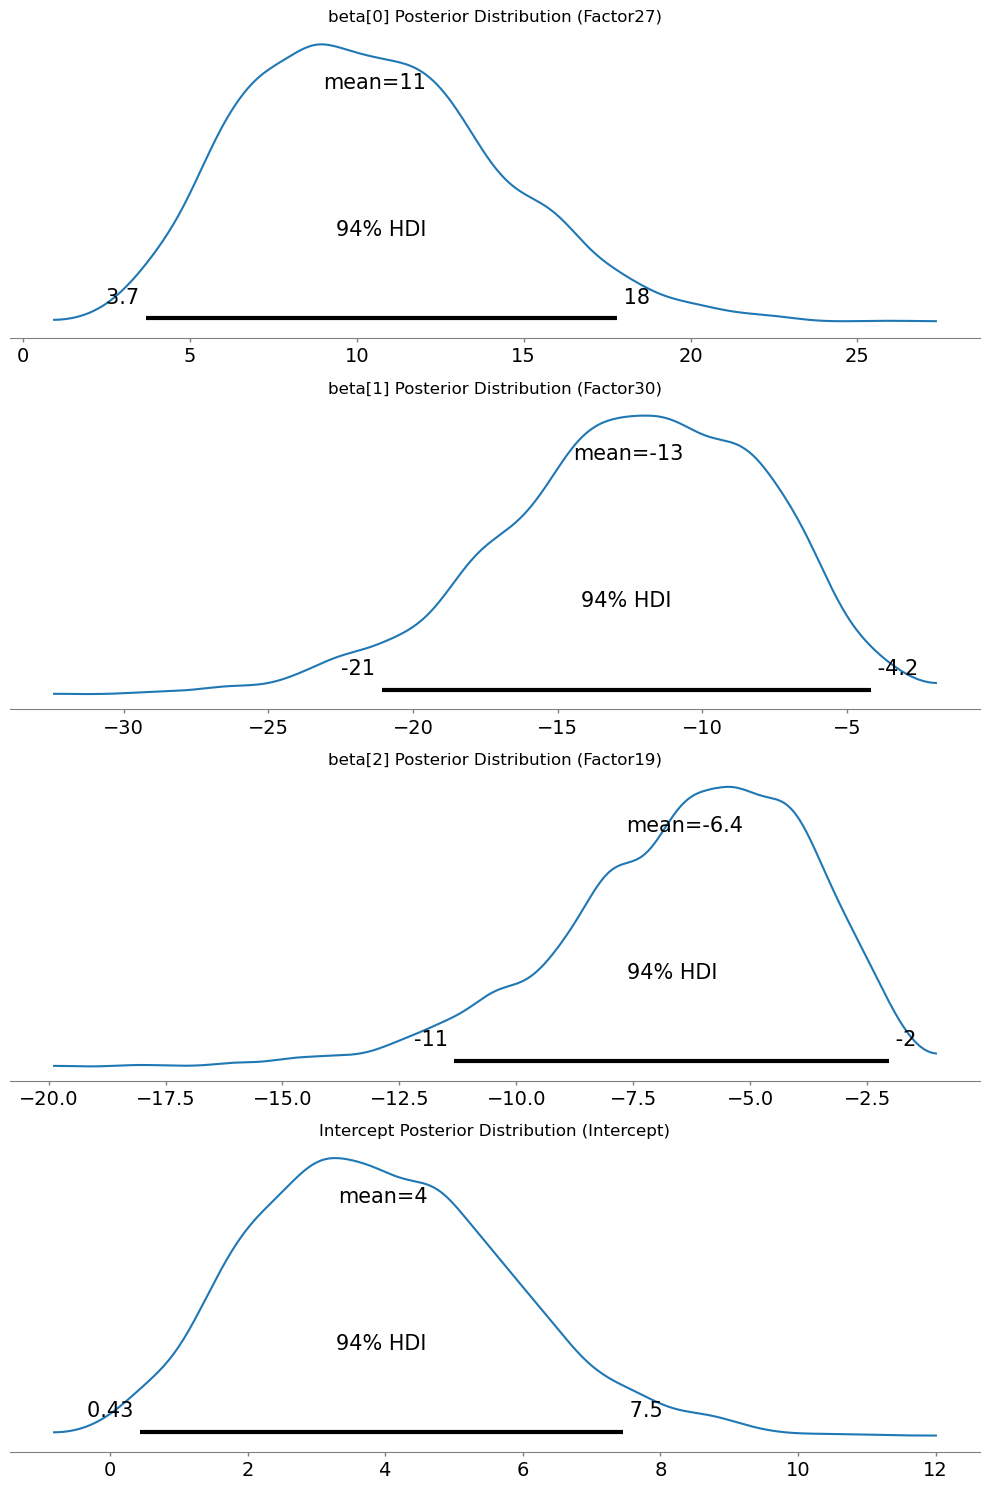

Sampling: [observed]


Accuracy: 0.9791666666666666
Classification Report:
              precision    recall  f1-score   support

       False       0.95      1.00      0.97        19
        True       1.00      0.97      0.98        29

    accuracy                           0.98        48
   macro avg       0.97      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48



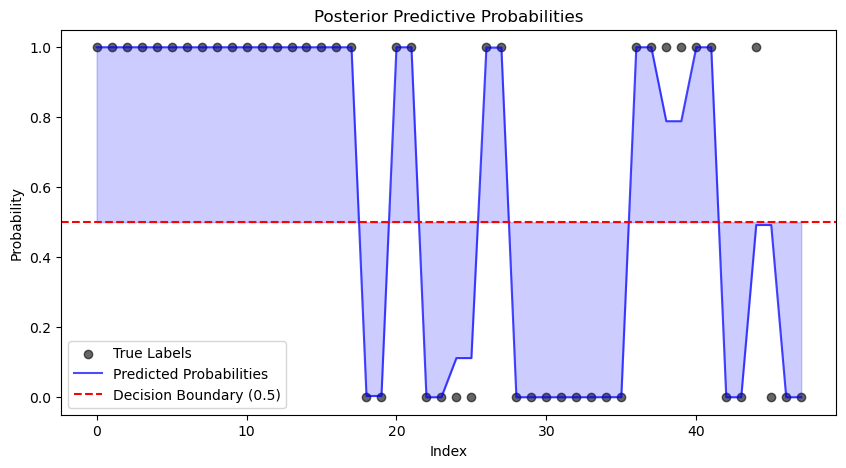

<Figure size 800x600 with 0 Axes>

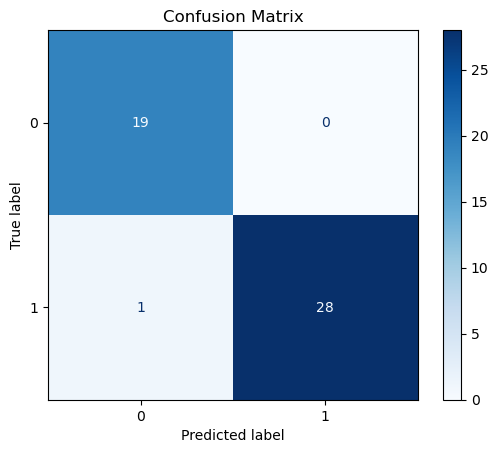

In [36]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

Selected_columns = ['Factor27', 'Factor30', 'Factor19']


X_select = []
y = []
indexes = []
for i in dfNi.index:
    indexes.append(i)
    X_select.append(list(standardized_data.iloc[i].values) + [
            dfNi['Structure_integrity_after_rxn'].iloc[i],
            dfNi['Ni_M_ratio'].iloc[i]
        ])
    if not pd.isna(dfNi['Selectivity_1'].iloc[i]):
        y.append(dfNi['Yield_1'].iloc[i] * (dfNi['Selectivity_1'].iloc[i]) > y_median)
    else:
        y.append(False)
        
    indexes.append(i)
    
    X_select.append(list(standardized_data.iloc[i].values) + [
            dfNi['Structure_integrity_after_rxn'].iloc[i],
            dfNi['Ni_M_ratio'].iloc[i]
        ])
    
    if not pd.isna(dfNi['Selectivity_2'].iloc[i]):
        y.append(dfNi['Yield_2'].iloc[i] * (dfNi['Selectivity_2'].iloc[i]) > y_median)
    else:
        y.append(False)
        

X_select = pd.DataFrame(X_select, index=indexes, columns=list(standardized_data.columns) + ['stability', 'Ni_M_ratio'])
y = pd.DataFrame(y, index=indexes, columns=['Class'])

# 
X_select = X_select[Selected_columns]

# 
with pm.Model() as bayesian_logistic_model:
    # 
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X_select.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # 
    linear_combination = pm.math.dot(X_select.values, beta) + intercept
    
    #  sigmoid
    p = pm.Deterministic("p", pm.math.sigmoid(linear_combination))
    
    # 
    observed = pm.Bernoulli("observed", p=p, observed=y['Class'].values)
    
    # 
    trace = pm.sample(1000, tune=2000, target_accept=0.95, random_seed=42)


# 
variable_names = X_select.columns.tolist()

fig, axes = plt.subplots(len(trace.posterior["beta"].values.T) + 1, 1, figsize=(10, 15))  # 每个参数一个子图
for i, ax in enumerate(axes[:-1]):
    az.plot_posterior(trace.posterior["beta"][:, :, i], ax=ax)
    # 
    ax.set_title(f"beta[{i}] Posterior Distribution ({variable_names[i]})")

# intercept
az.plot_posterior(trace.posterior["intercept"], ax=axes[-1])
axes[-1].set_title("Intercept Posterior Distribution (Intercept)")

plt.tight_layout()
plt.show()

# 
with bayesian_logistic_model:
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
# 
beta_samples = trace.posterior["beta"].mean(axis=(0, 1)).values
intercept_sample = trace.posterior["intercept"].mean(axis=(0, 1)).values

# 
linear_combination = np.dot(X_select.values, beta_samples) + intercept_sample
pred_mean = 1 / (1 + np.exp(-linear_combination))  # Sigmoid
y_pred = (pred_mean > 0.5).astype(int)

# 
accuracy = accuracy_score(y['Class'].values, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y['Class'].values, y_pred))

# 
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(y)), y['Class'], label="True Labels", alpha=0.6, color="black")
plt.plot(np.arange(len(y)), pred_mean, label="Predicted Probabilities", alpha=0.7, color="blue")
plt.axhline(0.5, linestyle="--", color="red", label="Decision Boundary (0.5)")
plt.fill_between(np.arange(len(y)), 0.5, pred_mean, alpha=0.2, color="blue")
plt.legend()
plt.xlabel("Index")
plt.ylabel("Probability")
plt.title("Posterior Predictive Probabilities")
plt.show()

# 
cm = confusion_matrix(y['Class'].values, y_pred)

# 
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

Trial: 0
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 1
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 2
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 3
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 4
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 5
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 6
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 7
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 8
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 9
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 10
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 11
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 12
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 13
Model: Logis

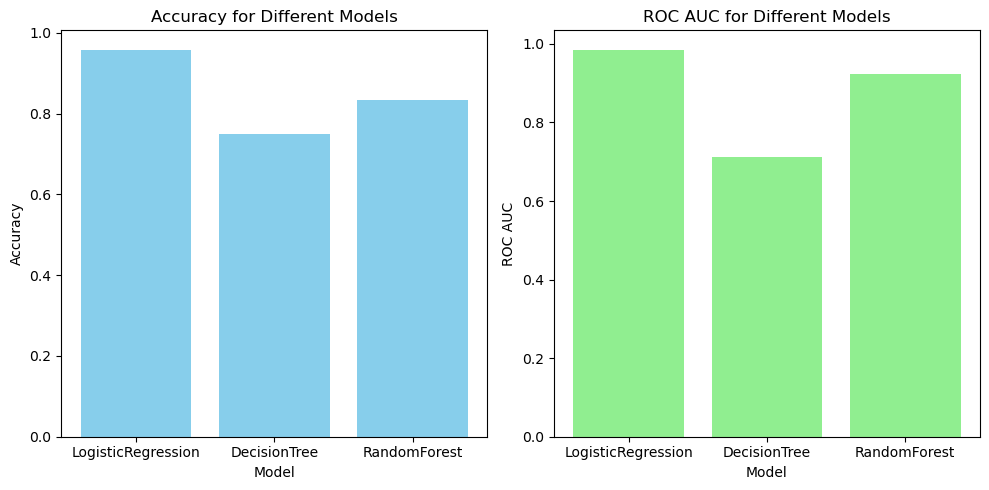

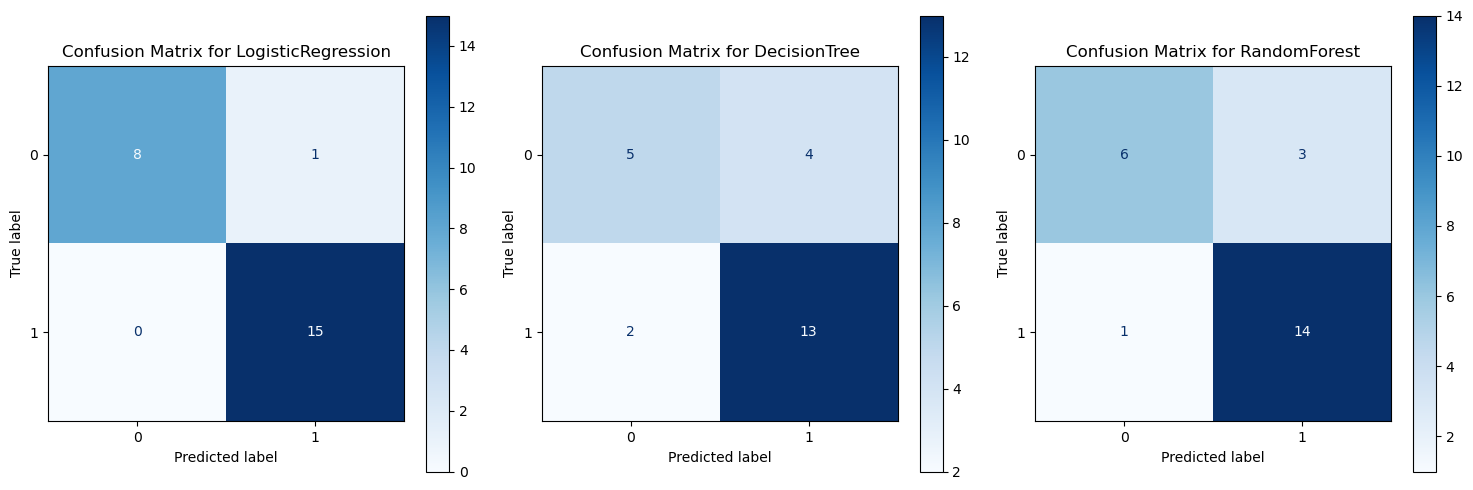

In [37]:
#LOO classification

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

Selected_columns = ['Factor27', 'Factor30', 'Factor19']

X_select = []
y = []
indexes = []
for i in dfNi.index:
    indexes.append(i)
    X_select.append(list(standardized_data.iloc[i].values) + [
            dfNi['Structure_integrity_after_rxn'].iloc[i],
            dfNi['Ni_M_ratio'].iloc[i]
        ])
    if not pd.isna(dfNi['Selectivity_1'].iloc[i]):
        y.append((dfNi['Yield_1'].iloc[i] * (dfNi['Selectivity_1'].iloc[i]) +
                  dfNi['Yield_2'].iloc[i] * (dfNi['Selectivity_2'].iloc[i])) / 2)
    else:
        y.append(0)

X_select = pd.DataFrame(X_select, index=indexes,
                        columns=list(standardized_data.columns) + ['stability', 'Ni_M_ratio'])

# Binarize y based on the median value
y_median = 0.025

# y_median = np.median(y)
y = [1 if value > y_median else 0 for value in y]
y = pd.DataFrame(y, index=indexes, columns=['Class'])

# LOO
num_sample = len(np.unique(indexes))

# 
test_and_predicted = [[] for _ in range(num_sample)]

# 
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}

X_select = X_select[Selected_columns]

trial_num = 0
for index in np.unique(indexes):
    print('Trial:', trial_num)
    # LOO DATASET
    X_train_val = X_select.drop([index])
    y_train_val = y.drop([index])
    X_test = X_select.loc[[index]]
    y_test = y.loc[[index]]

    for model_name, model in models.items():
        print(f"Model: {model_name}")
        # 
        model.fit(X_train_val, y_train_val.values.flatten())
        # 
        y_pred_test = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:, 1]  #
        # 
        test_and_predicted[trial_num].append([y_test.values[0][0], y_pred_test[0], y_pred_prob[0]])

    trial_num += 1



# 
models_list = list(models.keys())
accuracy_values = []
roc_auc_values = []
confusion_matrices = []  # 
test_and_predicted = np.array(test_and_predicted)

# 
for i in range(len(models_list)):
    true_values = test_and_predicted[:, i, 0].astype(int)
    predicted_values = test_and_predicted[:, i, 1].astype(int)
    predicted_probs = test_and_predicted[:, i, 2]

    #  Accuracy + ROC_AUC
    accuracy = accuracy_score(true_values, predicted_values)
    roc_auc = roc_auc_score(true_values, predicted_probs)

    accuracy_values.append(accuracy)
    roc_auc_values.append(roc_auc)

    # 
    cm = confusion_matrix(true_values, predicted_values)
    confusion_matrices.append(cm)

# 
for model_name, accuracy, roc_auc in zip(models_list, accuracy_values, roc_auc_values):
    print(f"{model_name}:")
    print(f"  Mean Accuracy: {accuracy:.4f}")
    print(f"  Mean ROC_AUC: {roc_auc:.4f}")

# 
plt.figure(figsize=(10, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.bar(models_list, accuracy_values, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Models')

# ROC_AUC
plt.subplot(1, 2, 2)
plt.bar(models_list, roc_auc_values, color='lightgreen')
plt.xlabel('Model')
plt.ylabel('ROC AUC')
plt.title('ROC AUC for Different Models')

plt.tight_layout()
plt.show()

#
plt.figure(figsize=(15, 5))
for i, cm in enumerate(confusion_matrices):
    plt.subplot(1, len(models_list), i + 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=plt.gca(), cmap="Blues", values_format="d")
    plt.title(f'Confusion Matrix for {models_list[i]}')

plt.tight_layout()
plt.show()

Trial: 0
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 1
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 2
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 3
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 4
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 5
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 6
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 7
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 8
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 9
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 10
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 11
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 12
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 13
Model: Logis

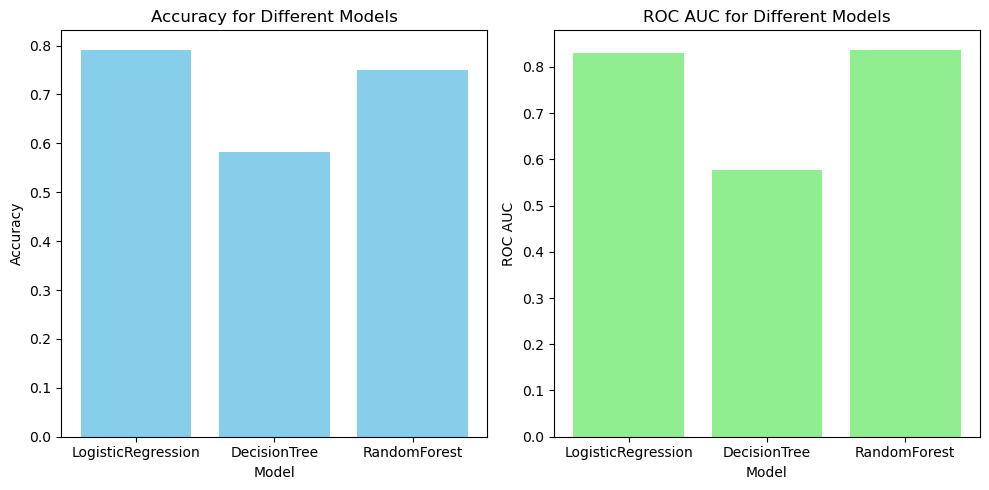

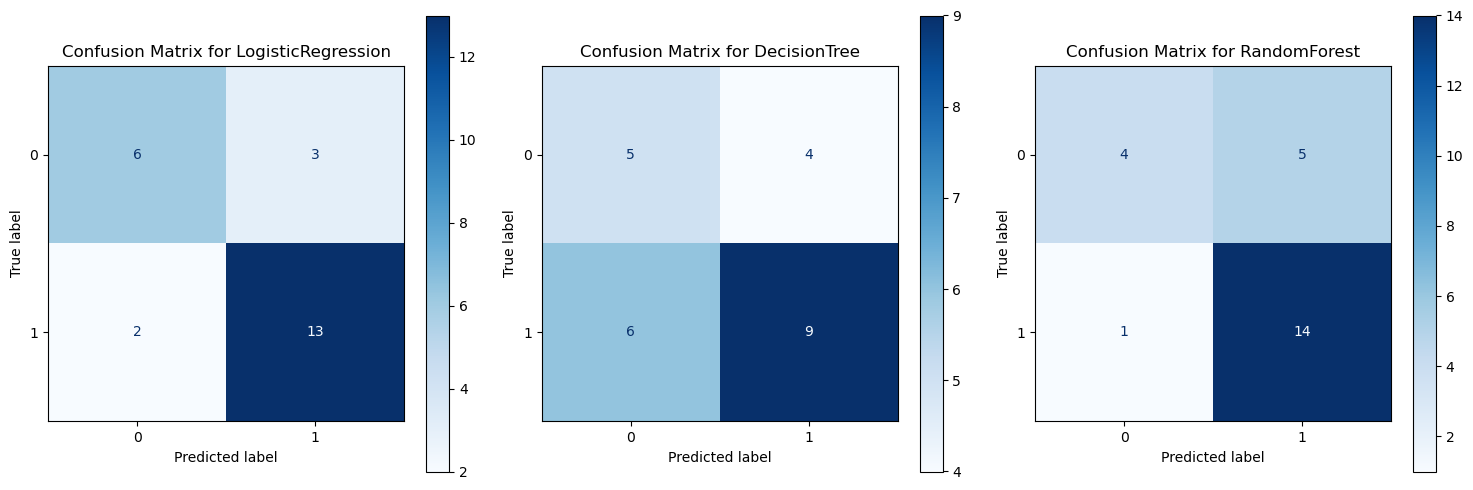

In [38]:
#LOO classification

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

X_select = []
y = []
indexes = []
for i in dfNi.index:
    indexes.append(i)
    X_select.append(list(standardized_data.iloc[i].values) + [
            dfNi['Structure_integrity_after_rxn'].iloc[i],
            dfNi['Ni_M_ratio'].iloc[i]
        ])
    if not pd.isna(dfNi['Selectivity_1'].iloc[i]):
        y.append((dfNi['Yield_1'].iloc[i] * (dfNi['Selectivity_1'].iloc[i]) +
                  dfNi['Yield_2'].iloc[i] * (dfNi['Selectivity_2'].iloc[i])) / 2)
    else:
        y.append(0)

X_select = pd.DataFrame(X_select, index=indexes,
                        columns=list(standardized_data.columns) + ['stability', 'Ni_M_ratio'])

# Binarize y based on the median value

y_median = 0.025
y = [1 if value > y_median else 0 for value in y]
y = pd.DataFrame(y, index=indexes, columns=['Class'])

# LOO
num_sample = len(np.unique(indexes))

# 
test_and_predicted = [[] for _ in range(num_sample)]

# 
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}

trial_num = 0
for index in np.unique(indexes):
    print('Trial:', trial_num)
    # LOO DATASET
    X_train_val = X_select.drop([index])
    y_train_val = y.drop([index])
    X_test = X_select.loc[[index]]
    y_test = y.loc[[index]]

    for model_name, model in models.items():
        print(f"Model: {model_name}")
        # 
        model.fit(X_train_val, y_train_val.values.flatten())
        # 
        y_pred_test = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:, 1]  #
        # 
        test_and_predicted[trial_num].append([y_test.values[0][0], y_pred_test[0], y_pred_prob[0]])

    trial_num += 1

# 
models_list = list(models.keys())
accuracy_values = []
roc_auc_values = []
confusion_matrices = []  # 
test_and_predicted = np.array(test_and_predicted)

# 
for i in range(len(models_list)):
    true_values = test_and_predicted[:, i, 0].astype(int)
    predicted_values = test_and_predicted[:, i, 1].astype(int)
    predicted_probs = test_and_predicted[:, i, 2]

    #  Accuracy + ROC_AUC
    accuracy = accuracy_score(true_values, predicted_values)
    roc_auc = roc_auc_score(true_values, predicted_probs)

    accuracy_values.append(accuracy)
    roc_auc_values.append(roc_auc)

    # 
    cm = confusion_matrix(true_values, predicted_values)
    confusion_matrices.append(cm)

# 
for model_name, accuracy, roc_auc in zip(models_list, accuracy_values, roc_auc_values):
    print(f"{model_name}:")
    print(f"  Mean Accuracy: {accuracy:.4f}")
    print(f"  Mean ROC_AUC: {roc_auc:.4f}")

# 
plt.figure(figsize=(10, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.bar(models_list, accuracy_values, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Models')

# ROC_AUC
plt.subplot(1, 2, 2)
plt.bar(models_list, roc_auc_values, color='lightgreen')
plt.xlabel('Model')
plt.ylabel('ROC AUC')
plt.title('ROC AUC for Different Models')

plt.tight_layout()
plt.show()

#
plt.figure(figsize=(15, 5))
for i, cm in enumerate(confusion_matrices):
    plt.subplot(1, len(models_list), i + 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=plt.gca(), cmap="Blues", values_format="d")
    plt.title(f'Confusion Matrix for {models_list[i]}')

plt.tight_layout()
plt.show()

Trial: 0
Model: LogisticRegression
Selected Features: ['Factor30']
Test Accuracy: 0.0
Test F1 Score: 0.0
Model: DecisionTree
Selected Features: ['Factor3', 'Factor4', 'Factor5', 'Factor6', 'Factor7', 'Factor8', 'Factor9', 'Factor10', 'Factor11', 'Factor12', 'Factor13', 'Factor14', 'Factor15', 'Factor16', 'Factor17', 'Factor18', 'Factor19', 'Factor20', 'Factor21', 'Factor22', 'Factor23', 'Factor24', 'Factor25', 'Factor26', 'Factor27', 'Factor28', 'Factor29', 'Factor30', 'Factor31', 'Factor32', 'Factor33', 'Factor34', 'Factor35', 'Factor36', 'Factor37', 'Factor38', 'Factor39', 'Factor40', 'Factor41', 'Factor42', 'Factor43', 'Factor44', 'Factor45', 'stability', 'Ni_M_ratio']
Test Accuracy: 0.0
Test F1 Score: 0.0
Model: RandomForest
Selected Features: ['Factor5', 'Factor21', 'Factor30']
Test Accuracy: 0.0
Test F1 Score: 0.0
Trial: 1
Model: LogisticRegression
Selected Features: ['Factor1', 'Factor10', 'Factor15', 'Factor22', 'Factor27', 'Factor30', 'Factor40']
Test Accuracy: 0.0
Test F1 Sco

c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor5']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: RandomForest


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor5', 'Factor15']
Test Accuracy: 1.0
Test F1 Score: 0.0
Trial: 12
Model: LogisticRegression
Selected Features: ['Factor15']
Test Accuracy: 0.0
Test F1 Score: 0.0
Model: DecisionTree


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor5', 'Factor24']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: RandomForest


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor5']
Test Accuracy: 1.0
Test F1 Score: 0.0
Trial: 13
Model: LogisticRegression
Selected Features: ['Factor15', 'Factor30']
Test Accuracy: 1.0
Test F1 Score: 1.0
Model: DecisionTree
Selected Features: ['Factor5']
Test Accuracy: 1.0
Test F1 Score: 1.0
Model: RandomForest
Selected Features: ['Factor5']
Test Accuracy: 1.0
Test F1 Score: 1.0
Trial: 14
Model: LogisticRegression


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor30']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: DecisionTree


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor5']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: RandomForest


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor1', 'Factor5', 'Factor6', 'Factor8', 'Factor9', 'Factor10', 'Factor15', 'Factor16', 'Factor17', 'Factor21', 'Factor23', 'Factor24', 'Factor27', 'Factor30', 'Factor40', 'Factor43']
Test Accuracy: 1.0
Test F1 Score: 0.0
Trial: 15
Model: LogisticRegression


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor30']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: DecisionTree


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor5']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: RandomForest


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor5', 'Factor6', 'Factor8', 'Factor9', 'Factor10', 'Factor15', 'Factor16', 'Factor17', 'Factor21', 'Factor24', 'Factor26', 'Factor27', 'Factor30', 'Factor39', 'Factor40', 'Factor43']
Test Accuracy: 1.0
Test F1 Score: 0.0
Trial: 16
Model: LogisticRegression
Selected Features: ['Factor15']
Test Accuracy: 0.0
Test F1 Score: 0.0
Model: DecisionTree


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor5', 'Factor6', 'Factor7', 'Factor8', 'Factor9', 'Factor10', 'Factor11', 'Factor12', 'Factor13', 'Factor14', 'Factor15', 'Factor16', 'Factor17', 'Factor18', 'Factor19', 'Factor20', 'Factor21', 'Factor22', 'Factor23', 'Factor24', 'Factor25', 'Factor26', 'Factor27', 'Factor28', 'Factor29', 'Factor30', 'Factor31', 'Factor32', 'Factor33', 'Factor34', 'Factor35', 'Factor36', 'Factor37', 'Factor38', 'Factor39', 'Factor40', 'Factor41', 'Factor42', 'Factor43', 'Factor44', 'Factor45', 'stability', 'Ni_M_ratio']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: RandomForest


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor1', 'Factor5', 'Factor6', 'Factor9', 'Factor10', 'Factor14', 'Factor15', 'Factor16', 'Factor17', 'Factor21', 'Factor26', 'Factor27', 'Factor30', 'Factor33', 'Factor34', 'Factor43']
Test Accuracy: 1.0
Test F1 Score: 0.0
Trial: 17
Model: LogisticRegression
Selected Features: ['Factor15', 'Factor30']
Test Accuracy: 0.0
Test F1 Score: 0.0
Model: DecisionTree
Selected Features: ['Factor5', 'Factor6', 'Factor7', 'Factor8', 'Factor9', 'Factor10', 'Factor11', 'Factor12', 'Factor13', 'Factor14', 'Factor15', 'Factor16', 'Factor36', 'Factor37', 'Factor38', 'Factor39', 'Factor40', 'Factor41', 'Factor42', 'Factor43', 'Factor44', 'Factor45', 'stability', 'Ni_M_ratio']
Test Accuracy: 0.0
Test F1 Score: 0.0
Model: RandomForest
Selected Features: ['Factor1', 'Factor5', 'Factor6', 'Factor10', 'Factor15', 'Factor16', 'Factor23', 'Factor27', 'Factor30', 'Factor34', 'Factor40']
Test Accuracy: 0.0
Test F1 Score: 0.0
Trial: 18
Model: LogisticRegression
Selected Features: ['Factor15

c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor1', 'Factor4', 'Factor9', 'Factor10', 'Factor13', 'Factor15', 'Factor16', 'Factor18', 'Factor22', 'Factor27', 'Factor30', 'Factor34', 'Factor35', 'Factor39', 'Factor40']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: DecisionTree


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor5', 'Factor6', 'Factor7', 'Factor8', 'Factor9', 'Factor10', 'Factor11', 'Factor12', 'Factor13', 'Factor14', 'Factor15', 'Factor16', 'Factor17', 'Factor18', 'Factor19', 'Factor20', 'Factor21', 'Factor22', 'Factor23', 'Factor24', 'Factor27', 'Factor28', 'Factor29', 'Factor30', 'Factor31', 'Factor32', 'Factor33', 'Factor34', 'Factor35', 'Factor36', 'Factor37', 'Factor38', 'Factor39', 'Factor40', 'Factor41', 'Factor42', 'Factor43', 'Factor44', 'Factor45', 'stability', 'Ni_M_ratio']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: RandomForest


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor5', 'Factor27']
Test Accuracy: 1.0
Test F1 Score: 0.0
Trial: 22
Model: LogisticRegression


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor15', 'Factor18', 'Factor27', 'Factor30']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: DecisionTree


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor5', 'Factor6', 'Factor7', 'Factor8', 'Factor9', 'Factor10', 'Factor11', 'Factor12', 'Factor13', 'Factor14', 'Factor15', 'Factor16', 'Factor17', 'Factor18', 'Factor19', 'Factor20', 'Factor21', 'Factor22', 'Factor23', 'Factor24', 'Factor27', 'Factor28', 'Factor29', 'Factor30', 'Factor31', 'Factor32', 'Factor33', 'Factor34', 'Factor35', 'Factor36', 'Factor37', 'Factor38', 'Factor39', 'Factor40', 'Factor41', 'Factor42', 'Factor43', 'Factor44', 'Factor45', 'stability', 'Ni_M_ratio']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: RandomForest


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor5', 'Factor16']
Test Accuracy: 1.0
Test F1 Score: 0.0
Trial: 23
Model: LogisticRegression


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor1', 'Factor5', 'Factor9', 'Factor10', 'Factor15', 'Factor16', 'Factor18', 'Factor22', 'Factor27', 'Factor30', 'Factor32', 'Factor34', 'Factor35', 'Factor39', 'Factor40']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: DecisionTree


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor5', 'Factor6', 'Factor7', 'Factor8', 'Factor9', 'Factor10', 'Factor11', 'Factor12', 'Factor13', 'Factor14', 'Factor15', 'Factor16', 'Factor17', 'Factor18', 'Factor19', 'Factor20', 'Factor21', 'Factor22', 'Factor23', 'Factor24', 'Factor27', 'Factor28', 'Factor29', 'Factor30', 'Factor31', 'Factor32', 'Factor33', 'Factor34', 'Factor35', 'Factor36', 'Factor37', 'Factor38', 'Factor39', 'Factor40', 'Factor41', 'Factor42', 'Factor43', 'Factor44', 'Factor45', 'stability', 'Ni_M_ratio']
Test Accuracy: 1.0
Test F1 Score: 0.0
Model: RandomForest


c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected Features: ['Factor5', 'Factor27']
Test Accuracy: 1.0
Test F1 Score: 0.0


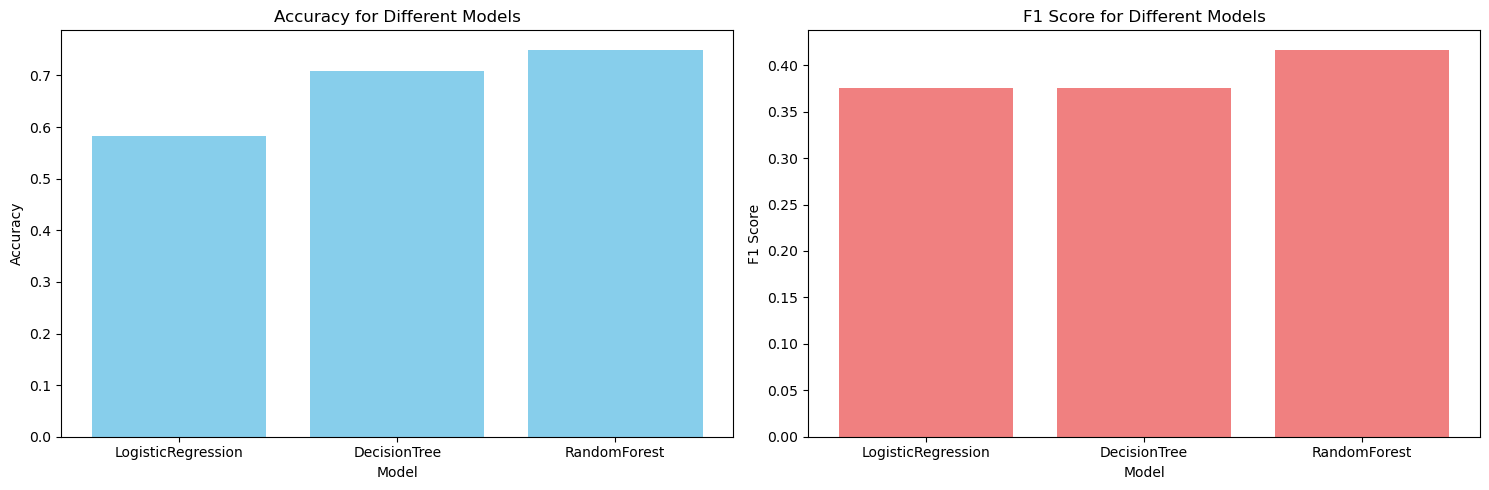

In [39]:
#sp2 activity, classification

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Data preparation (Assuming dfNi and standardized_data are already defined)
X_select = []
y = []
indexes = []
for i in dfNi.index:
    indexes.append(i)
    X_select.append(list(standardized_data.iloc[i].values) + [
            dfNi['Structure_integrity_after_rxn'].iloc[i],
            dfNi['Ni_M_ratio'].iloc[i]
        ])
    if not pd.isna(dfNi['Selectivity_1'].iloc[i]):
        y.append((dfNi['Yield_1'].iloc[i] * (1 - dfNi['Selectivity_1'].iloc[i]) +
                  dfNi['Yield_2'].iloc[i] * (1 - dfNi['Selectivity_2'].iloc[i])) / 2)
    else:
        y.append(0)

X_select = pd.DataFrame(X_select, index=indexes,
                        columns=list(standardized_data.columns) + ['stability', 'Ni_M_ratio'])

# Binarize y based on the median value
y_median = 0.025
y = [1 if value > y_median else 0 for value in y]
y = pd.DataFrame(y, index=indexes, columns=['Class'])

# Define the number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
num_sample = len(np.unique(indexes))

# Store selected predictors
Selected_Factors = [[] for _ in range(num_sample)]
Accuracies = [[] for _ in range(num_sample)]
F1s = [[] for _ in range(num_sample)]

# Different models to try
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}

trial_num = 0
for index in np.unique(indexes):
    print('Trial:', trial_num)
    # Build the LOO dataset by removing the current group
    X_train_val = X_select.drop([index])
    y_train_val = y.drop([index])
    X_test = X_select.loc[[index]]
    y_test = y.loc[[index]]

    for model_name, model in models.items():
        print(f"Model: {model_name}")

        # Recursive Feature Elimination with Cross-Validation for feature selection
        selector = RFECV(estimator=model, step=1, cv=kf, scoring='accuracy')
        selector = selector.fit(X_train_val, y_train_val.values.flatten())
        selected_features = X_train_val.columns[selector.support_]

        # Fit the model with selected features
        model.fit(X_train_val[selected_features], y_train_val.values.flatten())

        # Predictions for the test set
        y_pred_test = model.predict(X_test[selected_features])

        # Evaluation metrics for test set
        acc_test = accuracy_score(y_test, y_pred_test)
        f1_test = f1_score(y_test, y_pred_test)

        # Store metrics
        Accuracies[trial_num].append(acc_test)
        F1s[trial_num].append(f1_test)

        # Output performance
        print('Selected Features:', selected_features.tolist())
        print(f"Test Accuracy: {acc_test}")
        print(f"Test F1 Score: {f1_test}")

        Selected_Factors[trial_num].append(selected_features.tolist())

    trial_num += 1

# Visualization of Accuracy and F1 metrics
models_list = list(models.keys())
accuracy_values = np.mean(Accuracies, axis=0)
f1_values = np.mean(F1s, axis=0)

plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.bar(models_list, accuracy_values, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Models')

# F1 Score plot
plt.subplot(1, 2, 2)
plt.bar(models_list, f1_values, color='lightcoral')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score for Different Models')

plt.tight_layout()
plt.show()


In [40]:
import numpy as np
from collections import Counter

# Assuming df_reordered is the DataFrame containing factor correlations and 'factor_counter' is already defined
threshold = 0.8  # Set the correlation threshold

# Step 1: Group factors ensuring all pairs within the group have correlation above the threshold
factor_groups = []
visited = set()

for i in df_reordered.columns:
    if i in visited:
        continue
    # Start a candidate group with factor 'i'
    candidate_group = [i]
    for j in df_reordered.columns:
        if j in visited or i == j:
            continue
        # Check if 'j' can be added to the candidate group (i.e., it meets the correlation threshold with all existing members)
        if all(abs(df_reordered.loc[factor, j]) >= threshold for factor in candidate_group):
            candidate_group.append(j)
            visited.add(j)
    visited.add(i)
    # Add the candidate group to the list
    factor_groups.append(candidate_group)

# Step 2: Compute factor frequency based on unique groups to avoid double counting
factor_counter_groupwise = Counter()
factor_accuracy_groupwise = {}

# Count occurrences and accumulate accuracy values without double counting within each entry
for i in range(len(Selected_Factors)):
    for factors, acc in zip(Selected_Factors[i], Accuracies[i]):
        if isinstance(factors, list):  # Ensure factors is a list before iterating
            counted_groups = set()
            for group in factor_groups:
                # Check if any factors in the group are present in the current list of factors
                group_factors_in_entry = [factor for factor in factors if factor in group]
                if group_factors_in_entry:
                    # Only count the first occurrence in the group to avoid double counting within the entry
                    first_factor = group_factors_in_entry[0]
                    if tuple(group) not in counted_groups:
                        factor_counter_groupwise[first_factor] += 1
                        if first_factor in factor_accuracy_groupwise:
                            factor_accuracy_groupwise[first_factor].append(acc)
                        else:
                            factor_accuracy_groupwise[first_factor] = [acc]
                        counted_groups.add(tuple(group))

# Calculate average accuracy for each factor without double counting
factor_avg_accuracy_groupwise = {factor: np.mean(accs) for factor, accs in factor_accuracy_groupwise.items()}

# Step 3: Sum the factor frequencies within each group ensuring no double counting within each group
grouped_factor_counter = {}

for group in factor_groups:
    # Create a name for the group by joining factor names with their individual frequencies
    group_name = " & ".join(f"{factor}({factor_counter_groupwise[factor]})" for factor in group)
    grouped_count = sum(factor_counter_groupwise[factor] for factor in group)
    grouped_factor_counter[group_name] = grouped_count

# Step 4: Output the grouped factors with their summed frequencies, sorted by frequency in descending order
print("\nGrouped Factors with Summed Frequencies and Average Accuracy (Sorted by Frequency):")
for group, count in sorted(grouped_factor_counter.items(), key=lambda x: x[1], reverse=True):
    avg_accuracy = np.mean(
        [factor_avg_accuracy_groupwise[factor] for factor in group.split(" & ") if factor in factor_avg_accuracy_groupwise]
    )
    print(f"{group}: Frequency = {count}, Avg Accuracy = {avg_accuracy:.4f}")



Grouped Factors with Summed Frequencies and Average Accuracy (Sorted by Frequency):
Factor5(49) & Factor24(0): Frequency = 49, Avg Accuracy = nan
Factor30(38): Frequency = 38, Avg Accuracy = nan
Factor15(33): Frequency = 33, Avg Accuracy = nan
Factor10(21): Frequency = 21, Avg Accuracy = nan
Factor27(20): Frequency = 20, Avg Accuracy = nan
Factor16(20): Frequency = 20, Avg Accuracy = nan
Factor40(18): Frequency = 18, Avg Accuracy = nan
Factor1(7) & Factor34(11): Frequency = 18, Avg Accuracy = nan
Factor9(17): Frequency = 17, Avg Accuracy = nan
Factor6(16): Frequency = 16, Avg Accuracy = nan
Factor18(15) & Factor38(1): Frequency = 16, Avg Accuracy = nan
Factor22(15): Frequency = 15, Avg Accuracy = nan
Factor43(15): Frequency = 15, Avg Accuracy = nan
Factor21(1) & Factor17(14): Frequency = 15, Avg Accuracy = nan
Factor39(15): Frequency = 15, Avg Accuracy = nan
Factor42(0) & Factor8(14): Frequency = 14, Avg Accuracy = nan
Factor35(2) & Factor12(12) & Factor28(0): Frequency = 14, Avg Accu

c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 52 seconds.


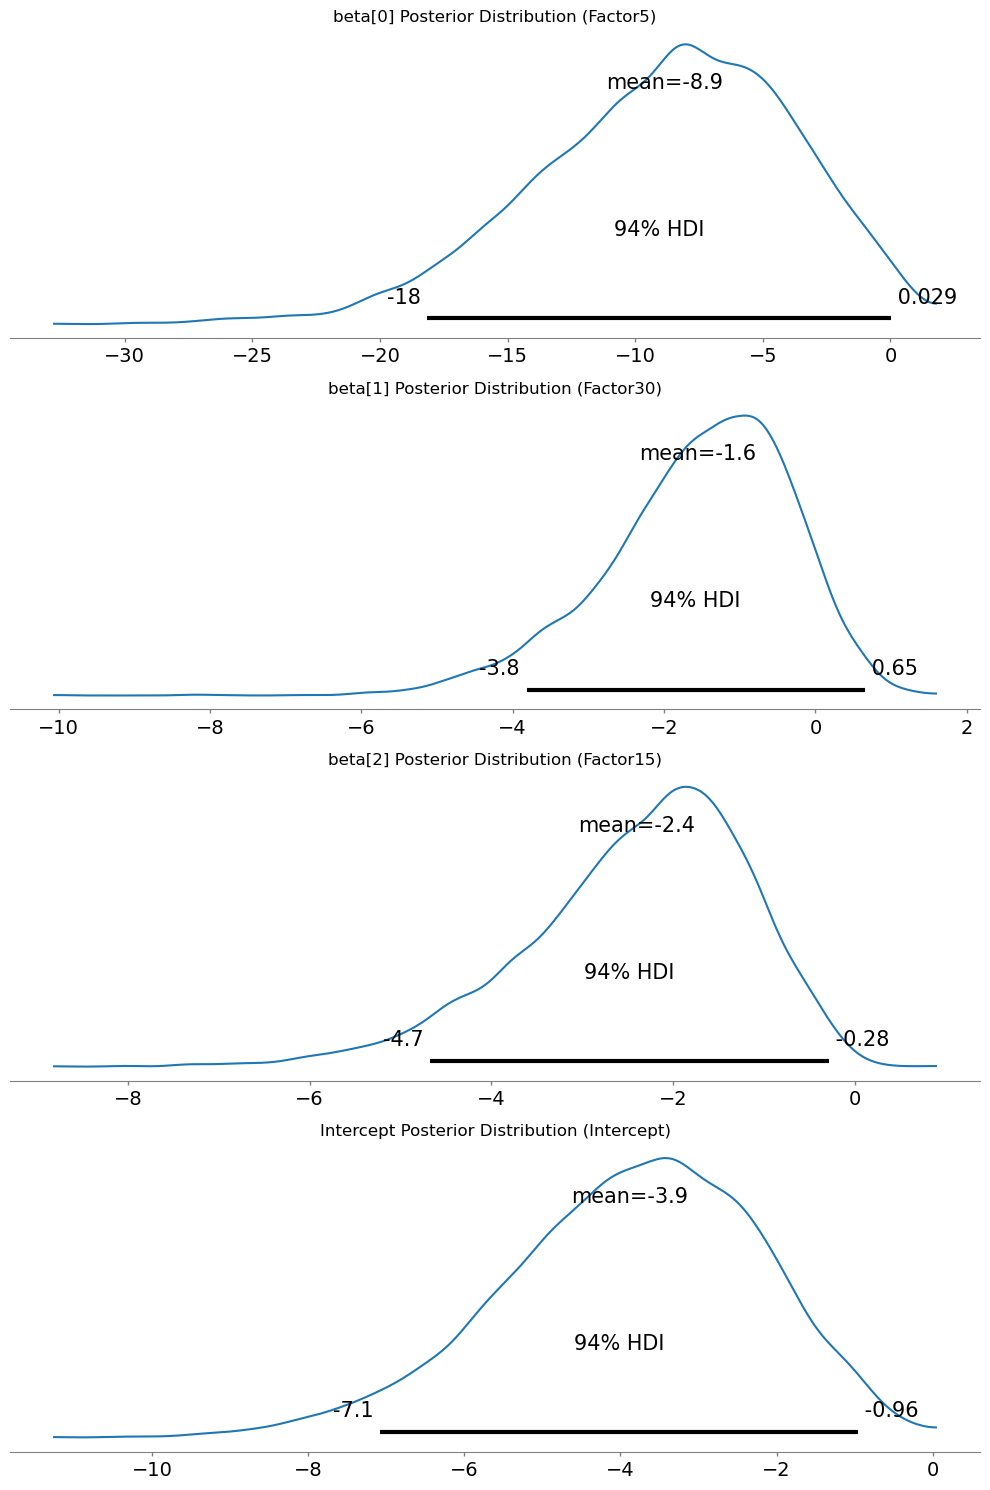

Sampling: [observed]


Accuracy: 0.875
Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.75      0.86        24
        True       0.80      1.00      0.89        24

    accuracy                           0.88        48
   macro avg       0.90      0.88      0.87        48
weighted avg       0.90      0.88      0.87        48



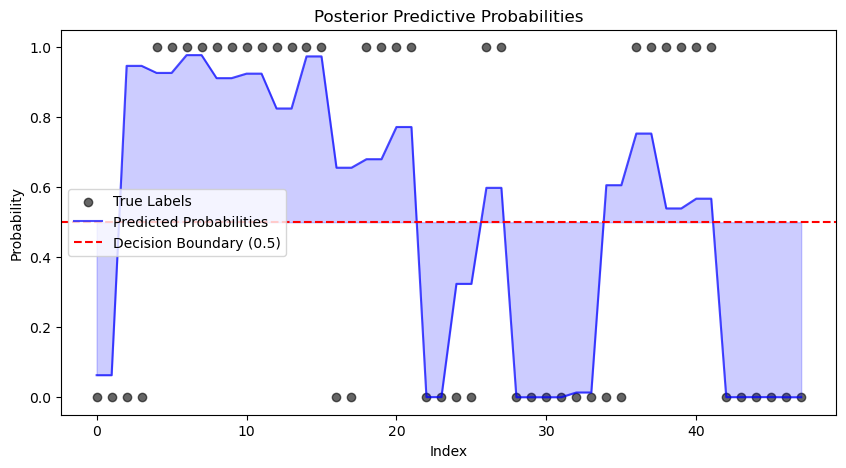

In [41]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
# 
from sklearn.metrics import accuracy_score, classification_report

# 
Selected_columns = ['Factor5', 'Factor30', 'Factor15']

X_select = []
y = []
indexes = []
for i in dfNi.index:
    indexes.append(i)
    X_select.append(list(standardized_data.iloc[i].values) + [
            dfNi['Structure_integrity_after_rxn'].iloc[i],
            dfNi['Ni_M_ratio'].iloc[i]
        ])
    if not pd.isna(dfNi['Selectivity_1'].iloc[i]):
        y.append(dfNi['Yield_1'].iloc[i] * (1 - dfNi['Selectivity_1'].iloc[i]) > y_median)
    else:
        y.append(False)
    indexes.append(i)
    X_select.append(list(standardized_data.iloc[i].values) + [
            dfNi['Structure_integrity_after_rxn'].iloc[i],
            dfNi['Ni_M_ratio'].iloc[i]
        ])
    if not pd.isna(dfNi['Selectivity_2'].iloc[i]):
        y.append(dfNi['Yield_2'].iloc[i] * (1 - dfNi['Selectivity_2'].iloc[i]) > y_median)
    else:
        y.append(False)

X_select = pd.DataFrame(X_select, index=indexes, columns=list(standardized_data.columns) + ['stability', 'Ni_M_ratio'])
y = pd.DataFrame(y, index=indexes, columns=['Class'])

# 
X_select = X_select[Selected_columns]

# 
with pm.Model() as bayesian_logistic_model:
    # 
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X_select.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # 
    linear_combination = pm.math.dot(X_select.values, beta) + intercept
    
    # sigmoid
    p = pm.Deterministic("p", pm.math.sigmoid(linear_combination))
    
    # 
    observed = pm.Bernoulli("observed", p=p, observed=y['Class'].values)
    
    # 
    trace = pm.sample(2000, tune=2000, target_accept=0.95, random_seed=42)

# 
variable_names = X_select.columns.tolist()

fig, axes = plt.subplots(len(trace.posterior["beta"].values.T) + 1, 1, figsize=(10, 15))  # 每个参数一个子图
for i, ax in enumerate(axes[:-1]):
    az.plot_posterior(trace.posterior["beta"][:, :, i], ax=ax)
    # 
    ax.set_title(f"beta[{i}] Posterior Distribution ({variable_names[i]})")

# intercept
az.plot_posterior(trace.posterior["intercept"], ax=axes[-1])
axes[-1].set_title("Intercept Posterior Distribution (Intercept)")

plt.tight_layout()
plt.show()

# 
with bayesian_logistic_model:
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
# 
beta_samples = trace.posterior["beta"].mean(axis=(0, 1)).values
intercept_sample = trace.posterior["intercept"].mean(axis=(0, 1)).values

# 
linear_combination = np.dot(X_select.values, beta_samples) + intercept_sample
pred_mean = 1 / (1 + np.exp(-linear_combination))  # Sigmoid
y_pred = (pred_mean > 0.5).astype(int)

# 
accuracy = accuracy_score(y['Class'].values, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y['Class'].values, y_pred))



#
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(y)), y['Class'], label="True Labels", alpha=0.6, color="black")
plt.plot(np.arange(len(y)), pred_mean, label="Predicted Probabilities", alpha=0.7, color="blue")
plt.axhline(0.5, linestyle="--", color="red", label="Decision Boundary (0.5)")
plt.fill_between(np.arange(len(y)), 0.5, pred_mean, alpha=0.2, color="blue")
plt.legend()
plt.xlabel("Index")
plt.ylabel("Probability")
plt.title("Posterior Predictive Probabilities")
plt.show()

Trial: 0
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 1
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 2
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 3
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 4
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 5
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 6
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 7
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 8
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 9
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 10
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 11
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 12
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 13
Model: Logis

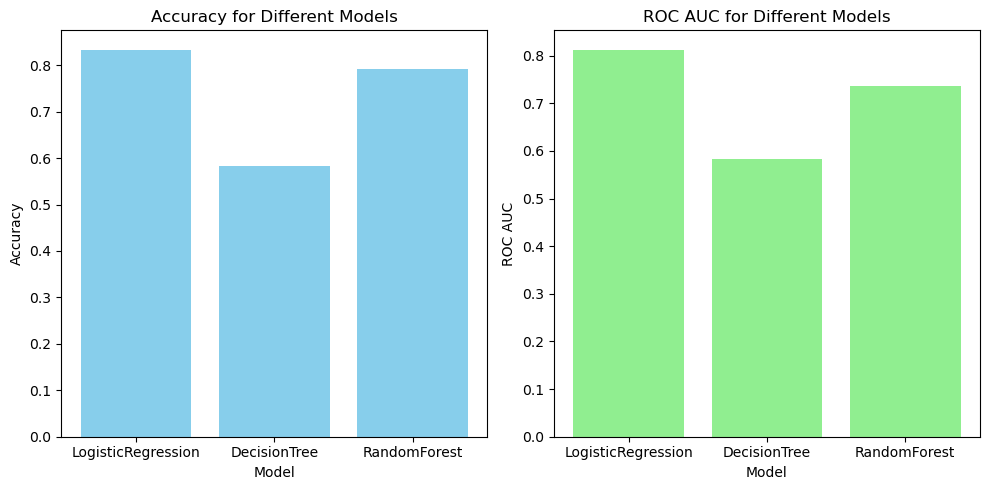

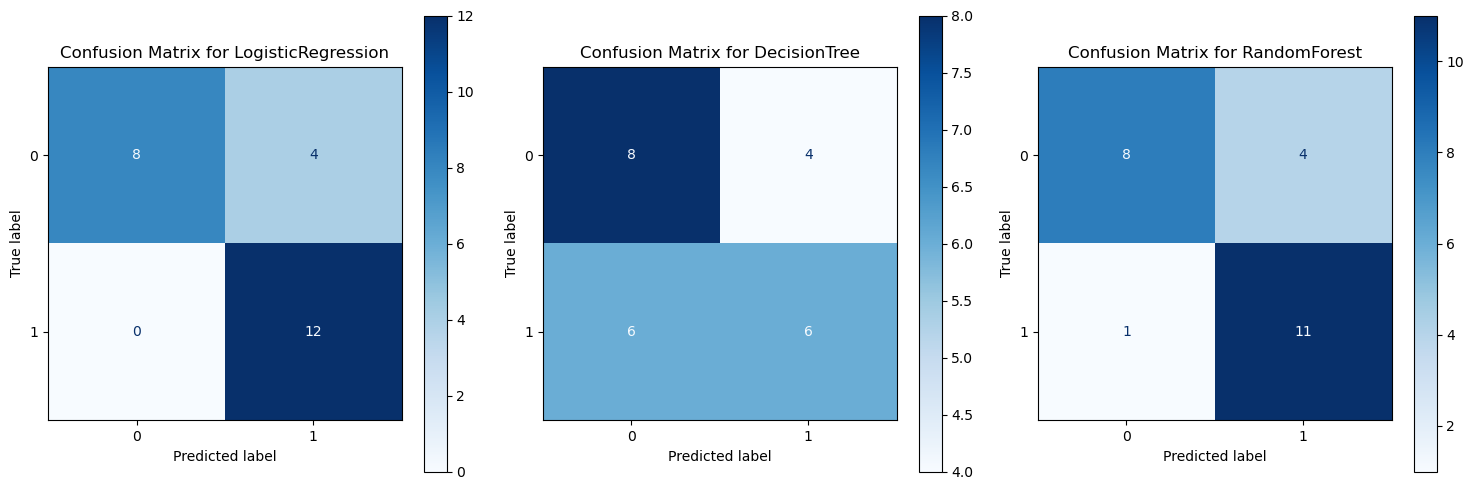

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

Selected_columns = ['Factor5', 'Factor30', 'Factor15']

X_select = []
y = []
indexes = []
for i in dfNi.index:
    indexes.append(i)
    X_select.append(list(standardized_data.iloc[i].values) + [
            dfNi['Structure_integrity_after_rxn'].iloc[i],
            dfNi['Ni_M_ratio'].iloc[i]
        ])
    if not pd.isna(dfNi['Selectivity_1'].iloc[i]):
        y.append((dfNi['Yield_1'].iloc[i] * (1 - dfNi['Selectivity_1'].iloc[i]) +
                  dfNi['Yield_2'].iloc[i] * (1 - dfNi['Selectivity_2'].iloc[i])) / 2)
    else:
        y.append(0)

X_select = pd.DataFrame(X_select, index=indexes,
                        columns=list(standardized_data.columns) + ['stability', 'Ni_M_ratio'])

# Binarize y based on the median value
y_median = 0.025
y = [1 if value > y_median else 0 for value in y]
y = pd.DataFrame(y, index=indexes, columns=['Class'])

X_select = X_select[Selected_columns]

# 
num_sample = len(np.unique(indexes))

# 
test_and_predicted = [[] for _ in range(num_sample)]

# 
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}

trial_num = 0
for index in np.unique(indexes):
    print('Trial:', trial_num)
    # LOO
    X_train_val = X_select.drop([index])
    y_train_val = y.drop([index])
    X_test = X_select.loc[[index]]
    y_test = y.loc[[index]]

    for model_name, model in models.items():
        print(f"Model: {model_name}")
        
        # 
        model.fit(X_train_val, y_train_val.values.flatten())
        
        # 
        y_pred_test = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:, 1] 

        #
        test_and_predicted[trial_num].append([y_test.values[0][0], y_pred_test[0], y_pred_prob[0]])

    trial_num += 1

#
models_list = list(models.keys())
accuracy_values = []
roc_auc_values = []
confusion_matrices = []  # 
test_and_predicted = np.array(test_and_predicted)

# 
for i in range(len(models_list)):
    true_values = test_and_predicted[:, i, 0].astype(int)
    predicted_values = test_and_predicted[:, i, 1].astype(int)
    predicted_probs = test_and_predicted[:, i, 2]

    # Accuracy and ROC_AUC
    accuracy = accuracy_score(true_values, predicted_values)
    roc_auc = roc_auc_score(true_values, predicted_probs)

    accuracy_values.append(accuracy)
    roc_auc_values.append(roc_auc)

    # 
    cm = confusion_matrix(true_values, predicted_values)
    confusion_matrices.append(cm)

# 
for model_name, accuracy, roc_auc in zip(models_list, accuracy_values, roc_auc_values):
    print(f"{model_name}:")
    print(f"  Mean Accuracy: {accuracy:.4f}")
    print(f"  Mean ROC_AUC: {roc_auc:.4f}")

# 
plt.figure(figsize=(10, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.bar(models_list, accuracy_values, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Models')

# ROC_AUC
plt.subplot(1, 2, 2)
plt.bar(models_list, roc_auc_values, color='lightgreen')
plt.xlabel('Model')
plt.ylabel('ROC AUC')
plt.title('ROC AUC for Different Models')

plt.tight_layout()
plt.show()

#
plt.figure(figsize=(15, 5))
for i, cm in enumerate(confusion_matrices):
    plt.subplot(1, len(models_list), i + 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=plt.gca(), cmap="Blues", values_format="d")
    plt.title(f'Confusion Matrix for {models_list[i]}')

plt.tight_layout()
plt.show()

Trial: 0
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 1
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 2
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 3
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 4
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 5
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 6
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 7
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 8
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 9
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 10
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 11
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 12
Model: LogisticRegression
Model: DecisionTree
Model: RandomForest
Trial: 13
Model: Logis

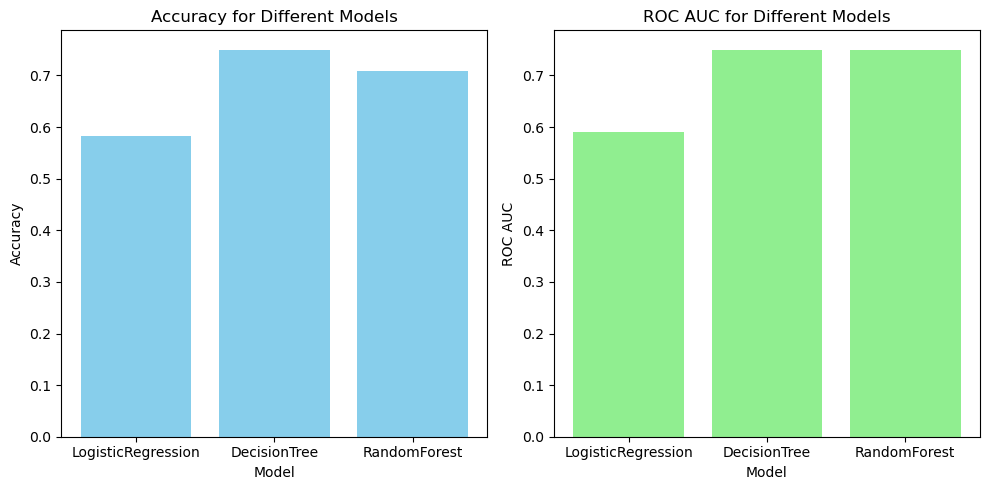

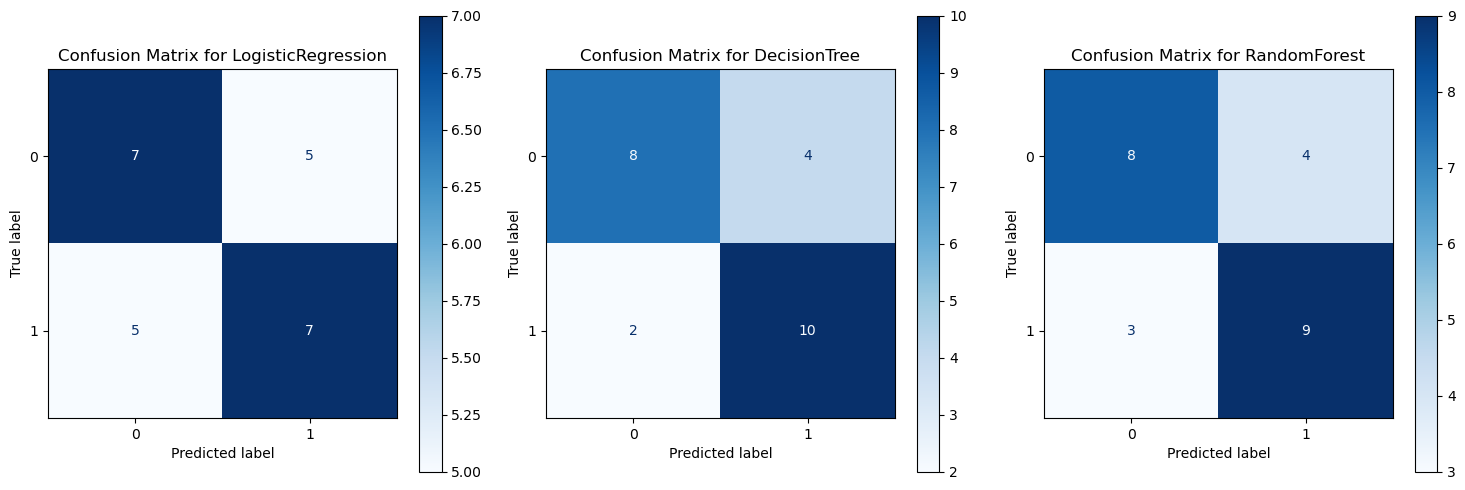

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

Selected_columns = ['Factor5', 'Factor30', 'Factor15']

X_select = []
y = []
indexes = []
for i in dfNi.index:
    indexes.append(i)
    X_select.append(list(standardized_data.iloc[i].values) + [
            dfNi['Structure_integrity_after_rxn'].iloc[i],
            dfNi['Ni_M_ratio'].iloc[i]
        ])
    if not pd.isna(dfNi['Selectivity_1'].iloc[i]):
        y.append((dfNi['Yield_1'].iloc[i] * (1 - dfNi['Selectivity_1'].iloc[i]) +
                  dfNi['Yield_2'].iloc[i] * (1 - dfNi['Selectivity_2'].iloc[i])) / 2)
    else:
        y.append(0)

X_select = pd.DataFrame(X_select, index=indexes,
                        columns=list(standardized_data.columns) + ['stability', 'Ni_M_ratio'])

# Binarize y based on the median value
y_median = 0.025
y = [1 if value > y_median else 0 for value in y]
y = pd.DataFrame(y, index=indexes, columns=['Class'])

# X_select = X_select[Selected_columns]

# 
num_sample = len(np.unique(indexes))

# 
test_and_predicted = [[] for _ in range(num_sample)]

# 
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}

trial_num = 0
for index in np.unique(indexes):
    print('Trial:', trial_num)
    # LOO
    X_train_val = X_select.drop([index])
    y_train_val = y.drop([index])
    X_test = X_select.loc[[index]]
    y_test = y.loc[[index]]

    for model_name, model in models.items():
        print(f"Model: {model_name}")
        
        # 
        model.fit(X_train_val, y_train_val.values.flatten())
        
        # 
        y_pred_test = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:, 1] 

        #
        test_and_predicted[trial_num].append([y_test.values[0][0], y_pred_test[0], y_pred_prob[0]])

    trial_num += 1

#
models_list = list(models.keys())
accuracy_values = []
roc_auc_values = []
confusion_matrices = []  # 
test_and_predicted = np.array(test_and_predicted)

# 
for i in range(len(models_list)):
    true_values = test_and_predicted[:, i, 0].astype(int)
    predicted_values = test_and_predicted[:, i, 1].astype(int)
    predicted_probs = test_and_predicted[:, i, 2]

    # Accuracy and ROC_AUC
    accuracy = accuracy_score(true_values, predicted_values)
    roc_auc = roc_auc_score(true_values, predicted_probs)

    accuracy_values.append(accuracy)
    roc_auc_values.append(roc_auc)

    # 
    cm = confusion_matrix(true_values, predicted_values)
    confusion_matrices.append(cm)

# 
for model_name, accuracy, roc_auc in zip(models_list, accuracy_values, roc_auc_values):
    print(f"{model_name}:")
    print(f"  Mean Accuracy: {accuracy:.4f}")
    print(f"  Mean ROC_AUC: {roc_auc:.4f}")

# 
plt.figure(figsize=(10, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.bar(models_list, accuracy_values, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Models')

# ROC_AUC
plt.subplot(1, 2, 2)
plt.bar(models_list, roc_auc_values, color='lightgreen')
plt.xlabel('Model')
plt.ylabel('ROC AUC')
plt.title('ROC AUC for Different Models')

plt.tight_layout()
plt.show()

#
plt.figure(figsize=(15, 5))
for i, cm in enumerate(confusion_matrices):
    plt.subplot(1, len(models_list), i + 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=plt.gca(), cmap="Blues", values_format="d")
    plt.title(f'Confusion Matrix for {models_list[i]}')

plt.tight_layout()
plt.show()